In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.distributions import *
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
from torchdeepretina.pyret_func import estfr
import pyret

In [4]:
optimum_para = {}
optimum_para['gaussian'] = [0.61, 0.56, 0.56, 0.66, 1., 0.94]
optimum_para['poisson1'] = [5.56, 8.87, 4.65, 4.75, 1., 1.49]
optimum_para['poisson2'] = [3.81, 5.03, 3.30, 3.11, 6.10, 0.82]
optimum_para['binomial'] = [2.17, 2.85, 1.91, 2.14, 1., 0.64]

t_list = [3,3,3,4,2,4]

In [5]:
lls = {'gaussian':[], 'poisson1':[], 'poisson2':[], 'binomial':[]}
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
recording = recording_stats(file_path, cells)
for cell in range(6):
    dist = distribution(t_list[cell])
    
    ll = dist.log_likelihood('truncated_gaussian', optimum_para['gaussian'][cell], recording.single_trial_bin, cell)
    lls['gaussian'].append(ll)
    
    ll = dist.log_likelihood('truncated_poisson', optimum_para['poisson1'][cell], recording.single_trial_bin, cell, p_version=1)
    lls['poisson1'].append(ll)
    
    ll = dist.log_likelihood('truncated_poisson', optimum_para['poisson2'][cell], recording.single_trial_bin, cell, p_version=2)
    lls['poisson2'].append(ll)
    
    ll = dist.log_likelihood('binomial_scale', optimum_para['binomial'][cell], recording.single_trial_bin, cell)
    lls['binomial'].append(ll)

In [7]:
single_trial_bin = recording.single_trial_bin

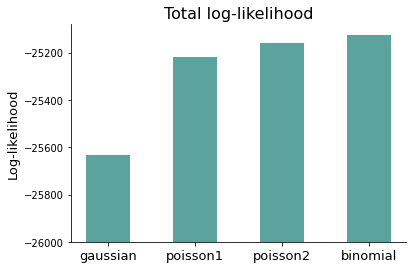

In [30]:
fig, ax = plt.subplots()
bottom = 26000
labels = lls.keys()
x = np.arange(len(labels))
y = np.array([sum(lls[key]) for key in lls.keys()]) + bottom
rect = ax.bar(x, y, color='#5DA39D', width=0.5, bottom = -bottom)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=13)
ax.set_ylabel('Log-likelihood', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Total log-likelihood', fontsize=16)
plt.show()

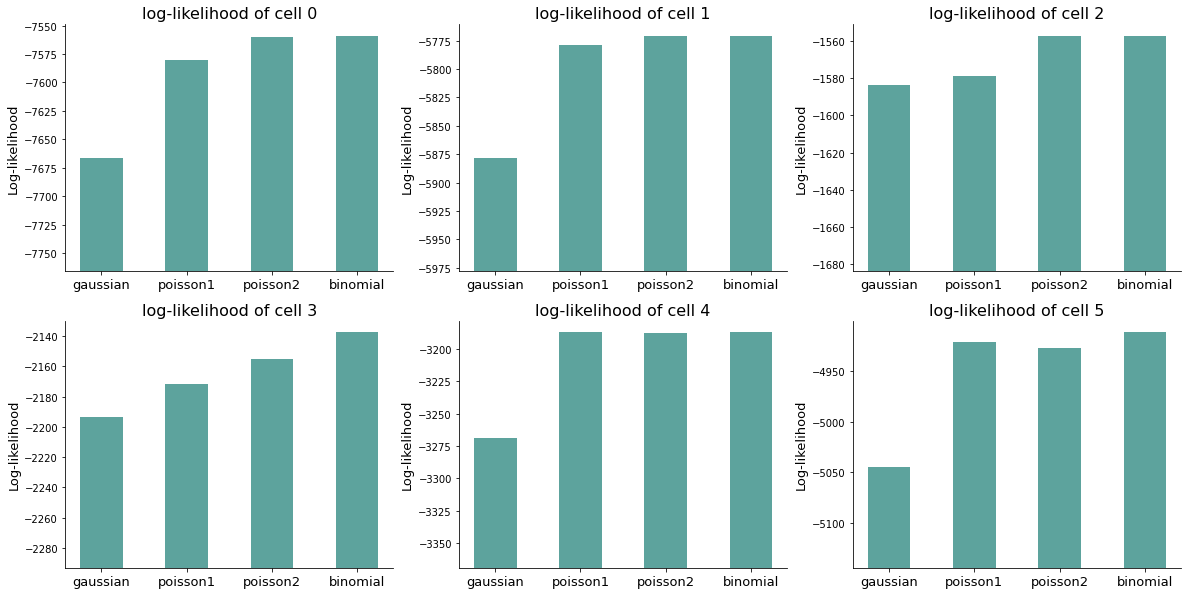

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range(6):
    bottom = - min([lls[key][i] for key in lls.keys()]) + 100
    labels = lls.keys()
    x = np.arange(len(labels))
    y = np.array([lls[key][i] for key in lls.keys()]) + bottom
    rect = ax[i//3, i%3].bar(x, y, color='#5DA39D', width=0.5, bottom = -bottom)
    ax[i//3, i%3].set_xticks(x)
    ax[i//3, i%3].set_xticklabels(labels, fontsize=13)
    ax[i//3, i%3].set_ylabel('Log-likelihood', fontsize=13)
    ax[i//3, i%3].spines['right'].set_visible(False)
    ax[i//3, i%3].spines['top'].set_visible(False)
    ax[i//3, i%3].set_title('log-likelihood of cell {}'.format(i), fontsize=16)
plt.show()

In [10]:
kls = {'gaussian':[], 'poisson1':[], 'poisson2':[], 'binomial':[]}
for cell in range(6):
    dist = distribution(t_list[cell])
    
    kl = dist.KL('truncated_gaussian', optimum_para['gaussian'][cell], recording, cell)
    kls['gaussian'].append(kl)
    
    kl = dist.KL('truncated_poisson', optimum_para['poisson1'][cell], recording, cell, p_version=1)
    kls['poisson1'].append(kl)
    
    kl = dist.KL('truncated_poisson', optimum_para['poisson2'][cell], recording, cell, p_version=2)
    kls['poisson2'].append(kl)
    
    kl = dist.KL('binomial_scale', optimum_para['binomial'][cell], recording, cell)
    kls['binomial'].append(kl)

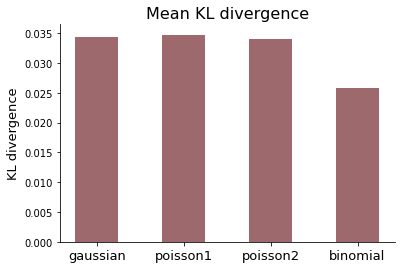

In [11]:
fig, ax = plt.subplots()
labels = kls.keys()
x = np.arange(len(labels))
y = np.array([sum(kls[key])/6 for key in kls.keys()])
rect = ax.bar(x, y, color='#9E696D', width=0.5)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=13)
ax.set_ylabel('KL divergence', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Mean KL divergence', fontsize=16)
plt.show()

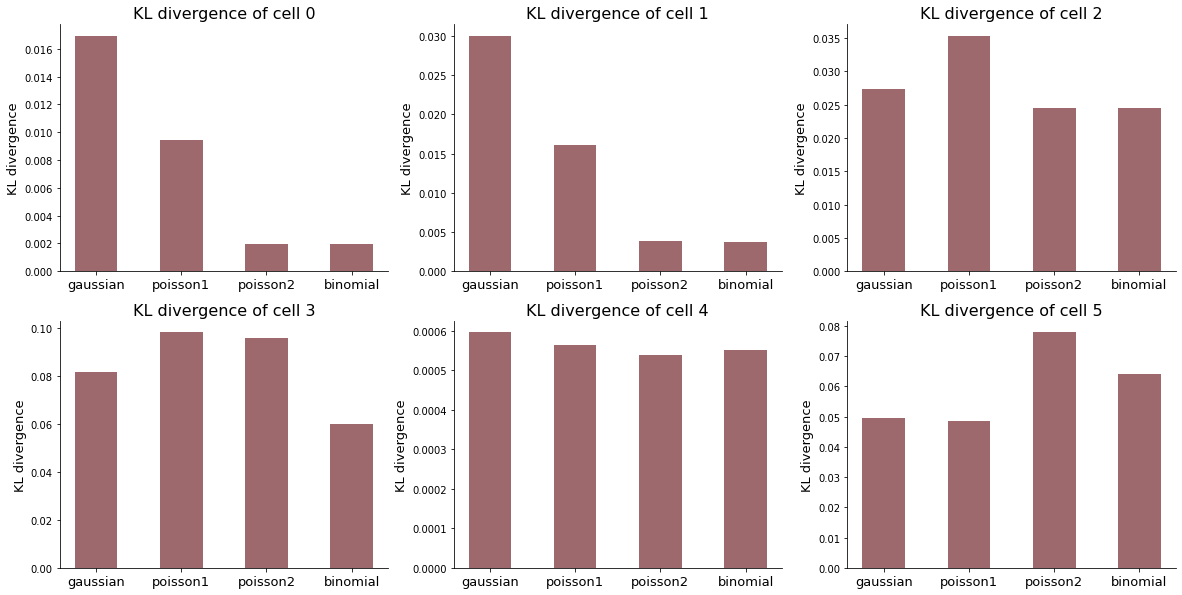

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range(6):
    labels = kls.keys()
    x = np.arange(len(labels))
    y = np.array([kls[key][i] for key in kls.keys()])
    rect = ax[i//3, i%3].bar(x, y, color='#9E696D', width=0.5)
    ax[i//3, i%3].set_xticks(x)
    ax[i//3, i%3].set_xticklabels(labels, fontsize=13)
    ax[i//3, i%3].set_ylabel('KL divergence', fontsize=13)
    ax[i//3, i%3].spines['right'].set_visible(False)
    ax[i//3, i%3].spines['top'].set_visible(False)
    ax[i//3, i%3].set_title('KL divergence of cell {}'.format(i), fontsize=16)
plt.show()

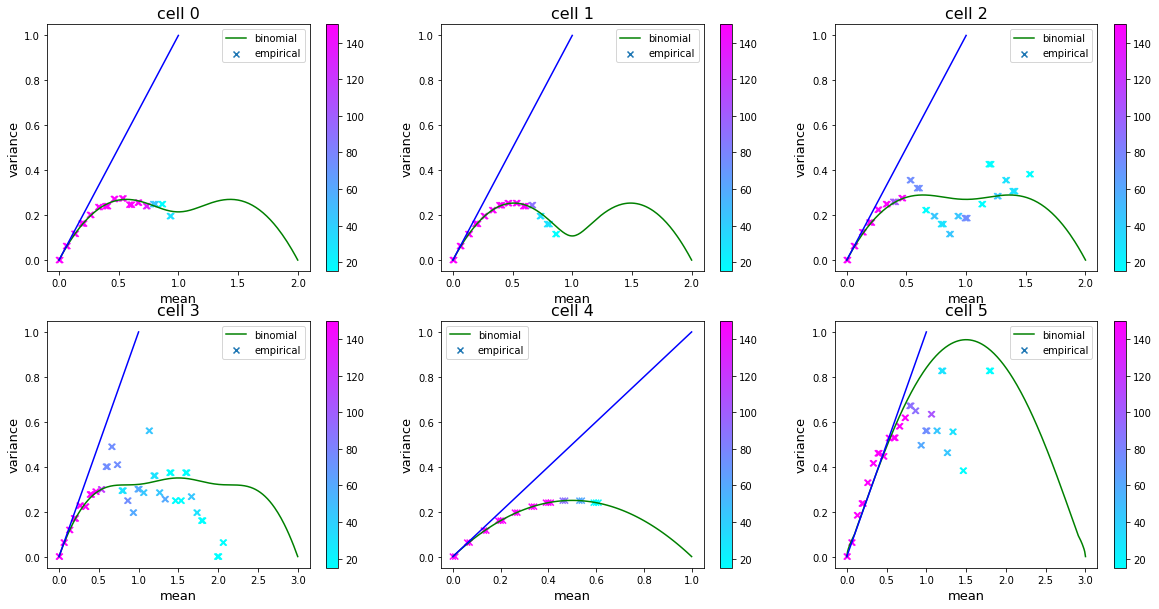

In [101]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for cell in range(6):
    dist = distribution(t_list[cell])
    means = []
    means_dis = []
    variances = []
    vars_dis = []
    weights = []
    for rate in range(100*t_list[cell]):
        mean, var, em, w = recording.stats_rate(100*recording.single_trial_bin.mean(0), cell, rate)
        if not np.isnan(mean):
            means.append(rate/100)
            variances.append(var)
            weights.append(w)
        try:
            r = dist.rate2para('binomial_scale', optimum_para['binomial'][cell], rate)
            var = dist.var('binomial_scale', r, optimum_para['binomial'][cell])
            means_dis.append(rate/100)
            vars_dis.append(var)
        except:
            pass
    p = ax[cell//3, cell%3].scatter(means, variances, c=weights, marker='x', cmap='cool', vmax=150, label='empirical')
    ax[cell//3, cell%3].plot(means_dis, vars_dis, 'g-', label='binomial')
    ax[cell//3, cell%3].plot([0, 1], [0, 1], 'b')
    ax[cell//3, cell%3].legend()
    ax[cell//3, cell%3].set_xlabel('mean', fontsize=13)
    ax[cell//3, cell%3].set_ylabel('variance', fontsize=13)
    ax[cell//3, cell%3].set_title('cell {}'.format(cell), fontsize=16)
    fig.colorbar(p, ax=ax[cell//3, cell%3])
plt.show()

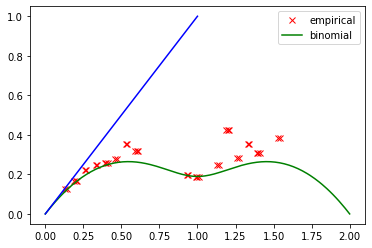

In [75]:
cell = 2
#k = optimum_para['binomial'][cell]
k = 2.3
dist = distribution(t_list[cell])
means = []
means_dis = []
variances = []
vars_dis = []
for rate in range(100*t_list[cell]):
    mean, var, em = recording.stats_rate(100*recording.single_trial_bin.mean(0), cell, rate)
    if not np.isnan(mean) and em[t_list[cell]-1]!=0:
        means.append(rate/100)
        variances.append(var)
    try:
        r = dist.rate2para('binomial_scale', k, rate)
        var = dist.var('binomial_scale', r, k)
        means_dis.append(rate/100)
        vars_dis.append(var)
    except:
        pass
plt.plot(means, variances, 'rx', label='empirical')
plt.plot(means_dis, vars_dis, 'g-', label='binomial')
plt.plot([0, 1], [0, 1], 'b')
plt.legend()
plt.show()

In [89]:
recording.stats_rate(recording.single_trial_bin.mean(0) * 100, cell=2, rate=121)[2]

array([0.13333333, 0.53333333, 0.33333333, 0.        , 0.        ])

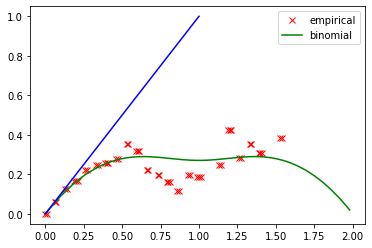

In [70]:
cell = 2
#k = optimum_para['binomial'][cell]
k = 3.3
dist = distribution(t_list[cell])
means = []
means_dis = []
variances = []
vars_dis = []
for rate in range(100*t_list[cell]):
    mean, var, em = recording.stats_rate(100*recording.single_trial_bin.mean(0), cell, rate)
    if not np.isnan(mean):
        means.append(rate/100)
        variances.append(var)
    try:
        r = dist.rate2para('truncated_poisson', k, rate, p_version=2)
        var = dist.var('truncated_poisson', r, k, p_version=2)
        means_dis.append(rate/100)
        vars_dis.append(var)
    except:
        pass
plt.plot(means, variances, 'rx', label='empirical')
plt.plot(means_dis, vars_dis, 'g-', label='binomial')
plt.plot([0, 1], [0, 1], 'b')
plt.legend()
plt.show()

In [19]:
[dist.binomial_scale(n, 0.5, k) for n in range(3)]

[0.05667909470247568, 0.8866418105950487, 0.05667909470247568]

In [31]:
recording.stats_rate(recording.single_trial_bin.mean(0) * 100, cell=2, rate=100)[2]

array([0.09333333, 0.81333333, 0.09333333, 0.        , 0.        ])

In [67]:
recording.stats_rate(recording.single_trial_bin.mean(0) * 100, cell=2, rate=47)[2]

array([0.54666667, 0.44      , 0.01333333, 0.        , 0.        ])

In [53]:
recording.stats_rate(recording.single_trial_bin.mean(0) * 100, cell=2, rate=86)[2]

array([0.13333333, 0.86666667, 0.        , 0.        , 0.        ])

In [68]:
recording.stats_rate(recording.single_trial_bin.mean(0) * 100, cell=2, rate=153)[2]

array([0.06666667, 0.33333333, 0.6       , 0.        , 0.        ])

In [148]:
for trial in range(15):
    print(recording.single_trial_bin[trial].max(0))

[2. 2. 2. 3. 1. 3.]
[2. 2. 2. 3. 1. 3.]
[2. 1. 2. 2. 1. 3.]
[2. 1. 2. 2. 1. 2.]
[2. 1. 2. 3. 1. 3.]
[2. 1. 2. 2. 1. 3.]
[2. 1. 2. 2. 1. 3.]
[2. 2. 2. 2. 1. 2.]
[2. 1. 2. 2. 1. 3.]
[2. 1. 2. 2. 1. 3.]
[2. 2. 2. 2. 1. 3.]
[2. 2. 2. 2. 1. 2.]
[2. 1. 2. 2. 1. 2.]
[2. 2. 2. 2. 1. 2.]
[2. 1. 2. 2. 1. 3.]


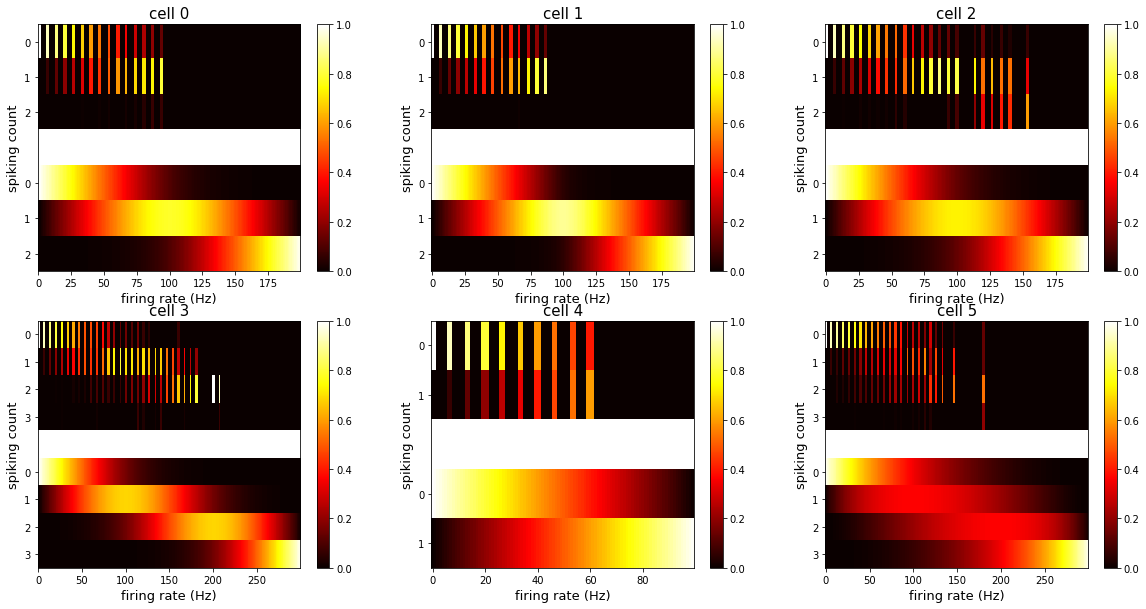

In [130]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for cell in range(6):
    dist = distribution(t_list[cell])
    ems = []
    ps = []
    means = []
    for rate in range(100*t_list[cell]):
        means.append(rate/100)
        mean, _, em = recording.stats_rate(100*recording.single_trial_bin.mean(0), cell, rate)
        if not np.isnan(mean):
            ems.append(em[:t_list[cell]])
        else:
            ems.append(np.zeros((t_list[cell])))
        try:
            r = dist.rate2para('binomial_scale', optimum_para['binomial'][cell], rate)
            p = np.array([dist.binomial_scale(i, r, optimum_para['binomial'][cell]) for i in range(t_list[cell])])
            ps.append(p)
        except:
            ps.append(np.zeros((t_list[cell])))
    ems = np.array(ems)
    ps = np.array(ps)
    means = np.array(means)
    
    max_index = max(np.where(ems!=0)[0].max(), np.where(ps!=0)[0].max())
    ems = ems[:max_index]
    ps = ps[:max_index]
    means = means[:max_index]
    full = np.concatenate((ems, np.ones((max_index, 1)), ps), axis=1)

    p = ax[cell//3, cell%3].imshow(full.T, aspect='auto', cmap='hot', interpolation='none')
    ax[cell//3, cell%3].set_yticks(list(range(t_list[cell]))+list(range(t_list[cell]+1, 2*t_list[cell]+1)))
    ax[cell//3, cell%3].set_xlabel('firing rate (Hz)', fontsize=13)
    ax[cell//3, cell%3].set_yticklabels(list(range(t_list[cell]))+list(range(t_list[cell])))
    ax[cell//3, cell%3].set_ylabel('spiking count', fontsize=13)
    ax[cell//3, cell%3].set_title('cell {}'.format(cell), fontsize=15)
    fig.colorbar(p, ax=ax[cell//3, cell%3])
plt.show()

In [140]:
dist = distribution(3)
single_trial_bin = recording.single_trial_bin
single_trial_bin[:,:,3][single_trial_bin[:,:,3]>2] = 2
dist.optimize_k('binomial_scale', single_trial_bin, 3)

1.6943359375

In [144]:
dist.KL('binomial_scale', 1.69, recording, 3)

0.00492727063412895

In [141]:
dist = distribution(3)
single_trial_bin = recording.single_trial_bin
single_trial_bin[:,:,5][single_trial_bin[:,:,5]>2] = 2
dist.optimize_k('binomial_scale', single_trial_bin, 5, a=0.3, b=2)

0.47265625

In [145]:
dist.KL('binomial_scale', 0.47, recording, 5)

0.020357458807095895

In [147]:
optimum_para['binomial'] = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]

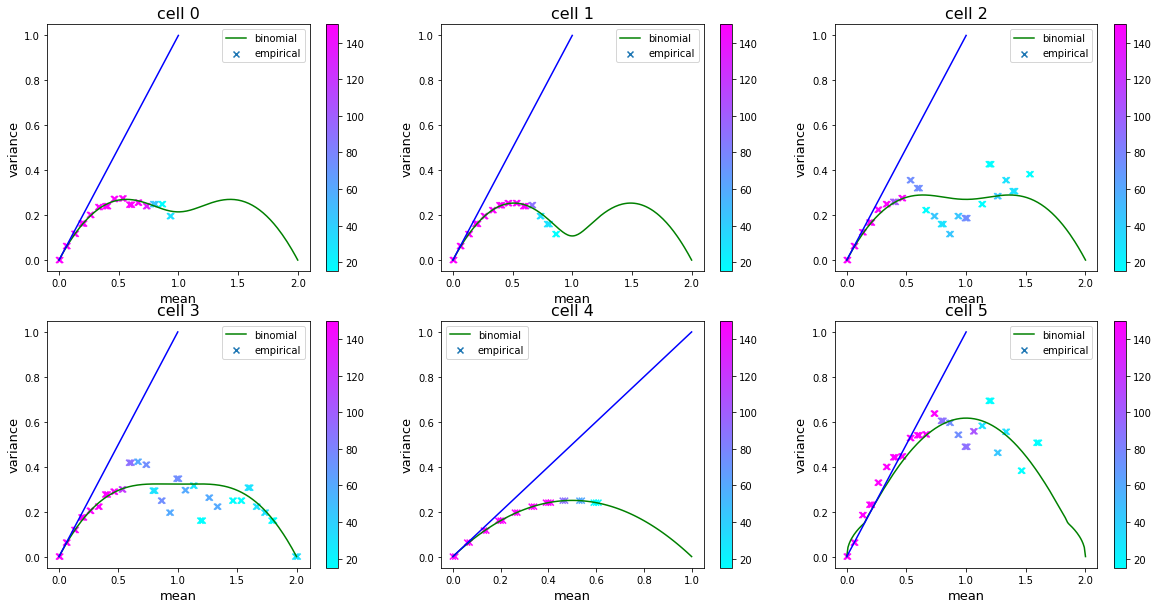

In [148]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for cell in range(6):
    dist = distribution(t_list[cell])
    means = []
    means_dis = []
    variances = []
    vars_dis = []
    weights = []
    for rate in range(100*t_list[cell]):
        mean, var, em, w = recording.stats_rate(100*recording.single_trial_bin.mean(0), cell, rate)
        if not np.isnan(mean):
            means.append(rate/100)
            variances.append(var)
            weights.append(w)
        try:
            r = dist.rate2para('binomial_scale', optimum_para['binomial'][cell], rate)
            var = dist.var('binomial_scale', r, optimum_para['binomial'][cell])
            means_dis.append(rate/100)
            vars_dis.append(var)
        except:
            pass
    p = ax[cell//3, cell%3].scatter(means, variances, c=weights, marker='x', cmap='cool', vmax=150, label='empirical')
    ax[cell//3, cell%3].plot(means_dis, vars_dis, 'g-', label='binomial')
    ax[cell//3, cell%3].plot([0, 1], [0, 1], 'b')
    ax[cell//3, cell%3].legend()
    ax[cell//3, cell%3].set_xlabel('mean', fontsize=13)
    ax[cell//3, cell%3].set_ylabel('variance', fontsize=13)
    ax[cell//3, cell%3].set_title('cell {}'.format(cell), fontsize=16)
    fig.colorbar(p, ax=ax[cell//3, cell%3])
plt.show()

In [184]:
single_trial_mean = single_trial_bin.mean(0)
pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(single_trial_mean.shape[1]):
    dist = distribution(t_list[cell])
    for t in range(single_trial_mean.shape[0]):
        rate = single_trial_mean[t, cell] * 100
        if rate == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para['binomial'][cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para['binomial'][cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], 15, p=p)
        pred_single_trial[:, t, cell] = spikes

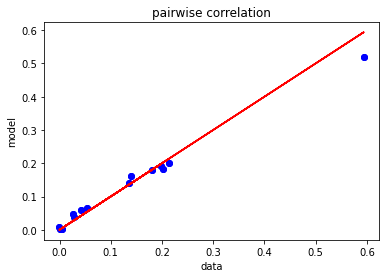

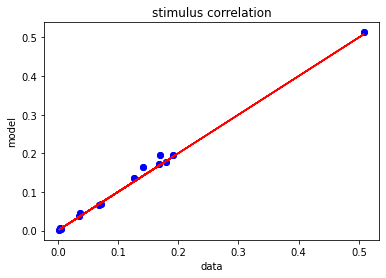

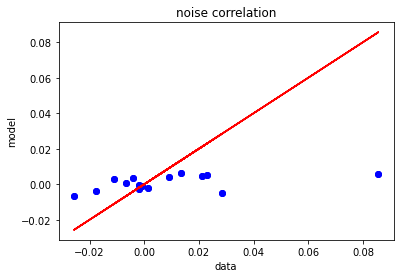

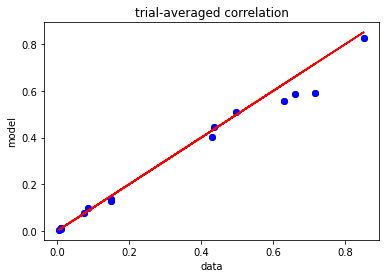

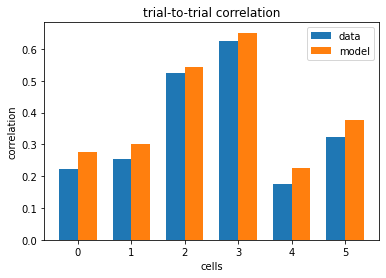

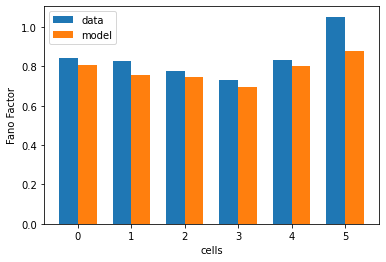

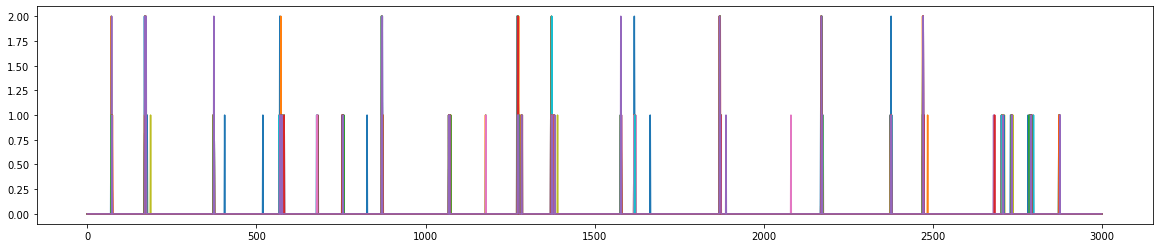

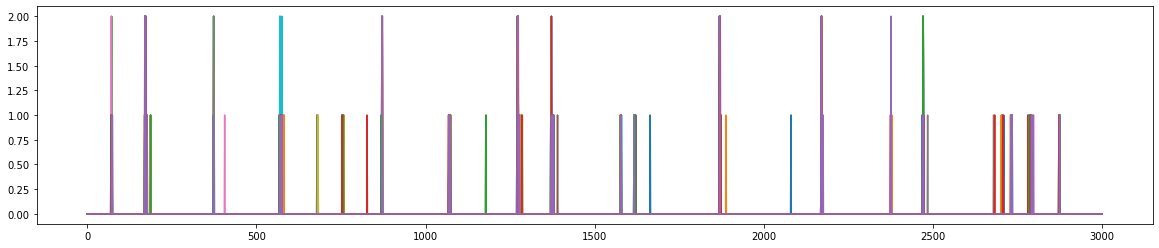

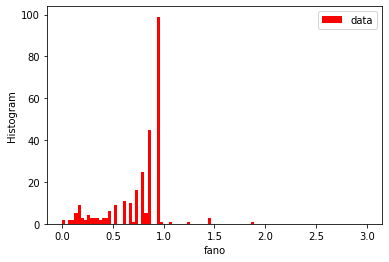

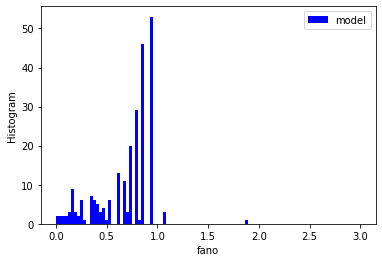

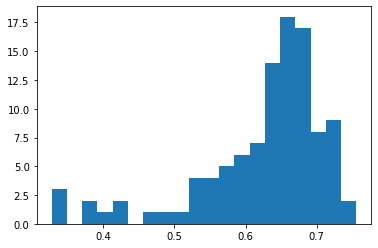

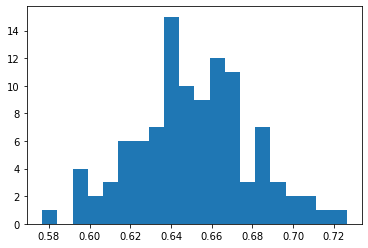

In [185]:
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial[i,:,cell], pred_single_trial[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

In [186]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

In [204]:
pred_single_trial = np.zeros(single_trial_bin.shape)
targ[targ<0] = 0
for cell in range(pred.shape[1]):
    dist = distribution(t_list[cell])
    for t in range(pred.shape[0]):
        rate = targ[t, cell]
        if rate == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para['binomial'][cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para['binomial'][cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], 15, p=p)
        pred_single_trial[:, t, cell] = spikes

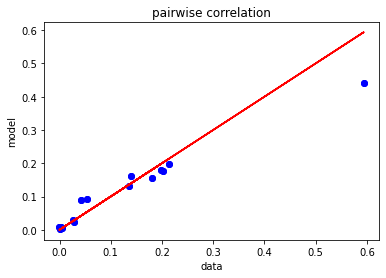

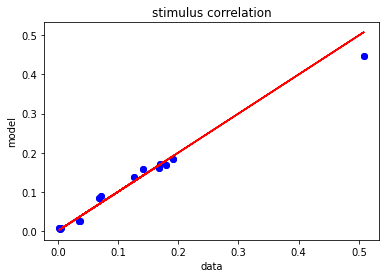

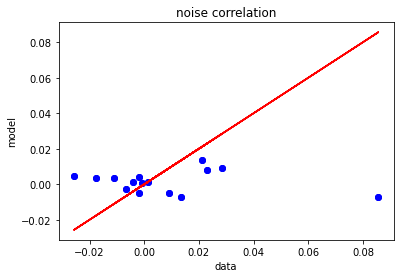

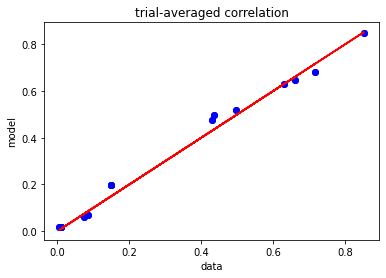

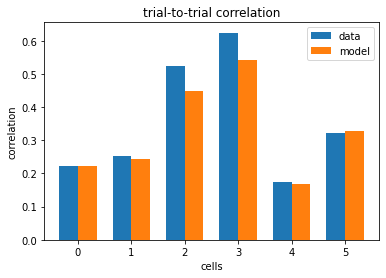

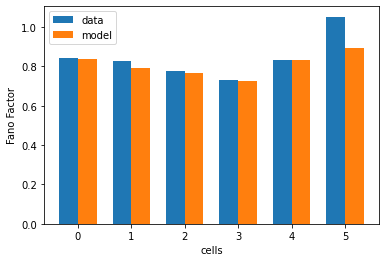

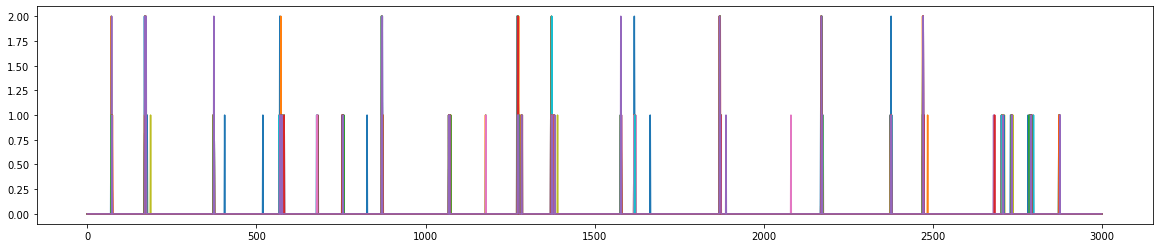

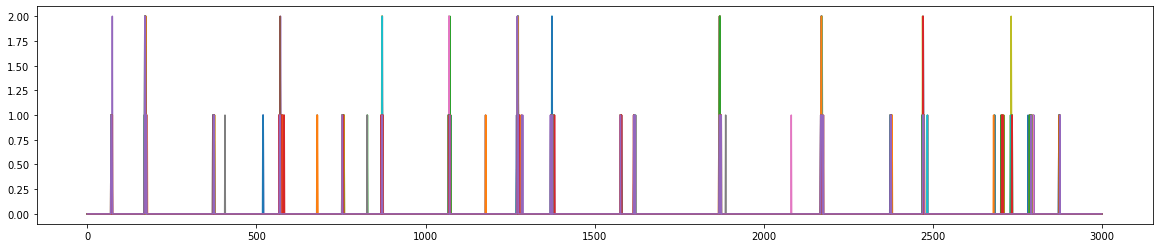

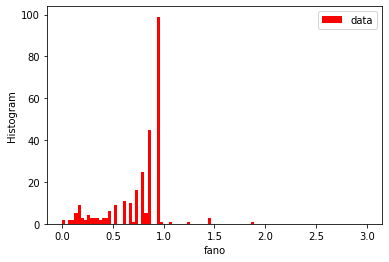

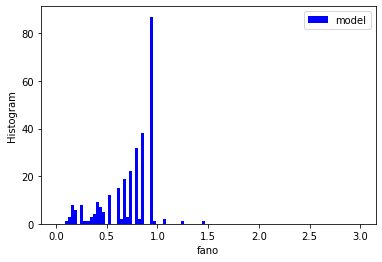

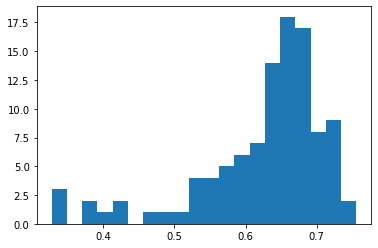

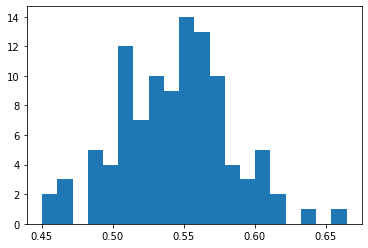

In [205]:
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial[i,:,cell], pred_single_trial[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

0.8444860886245289


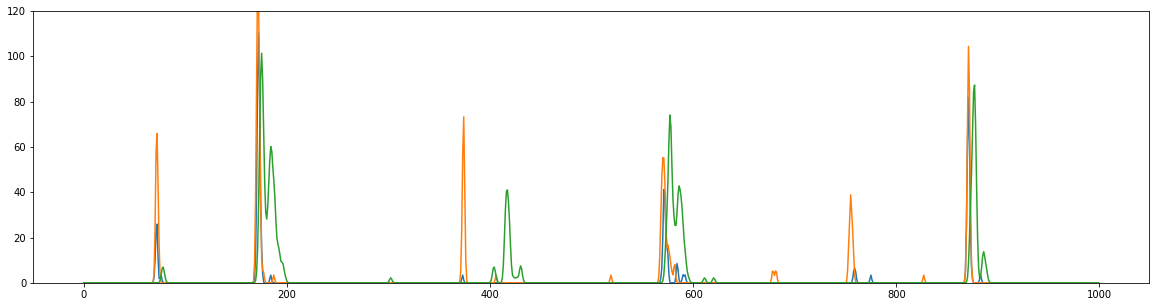

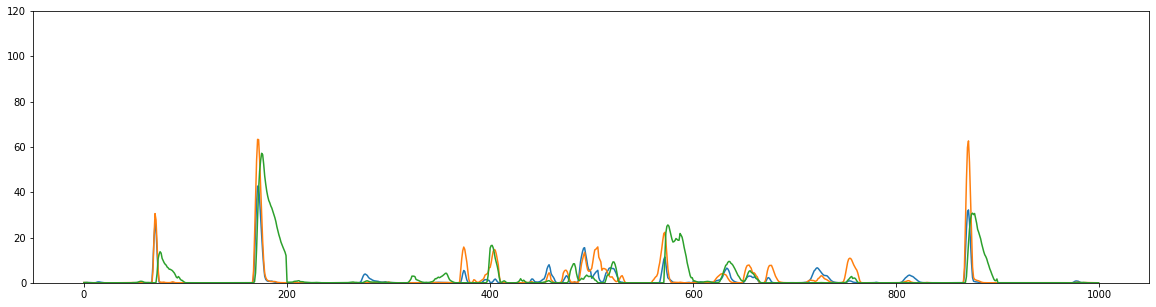

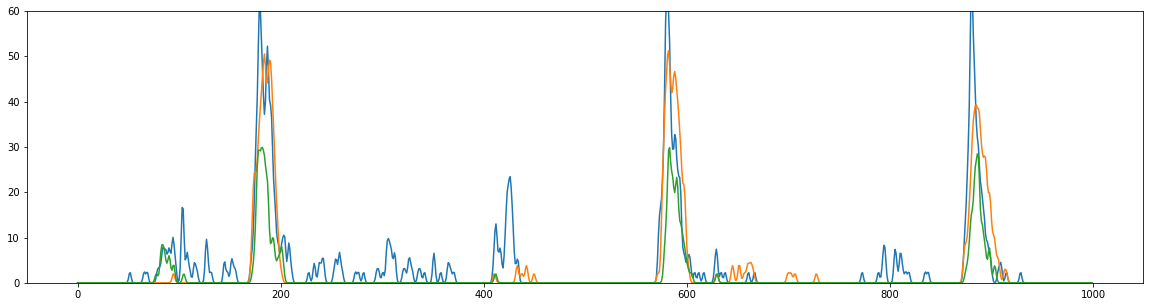

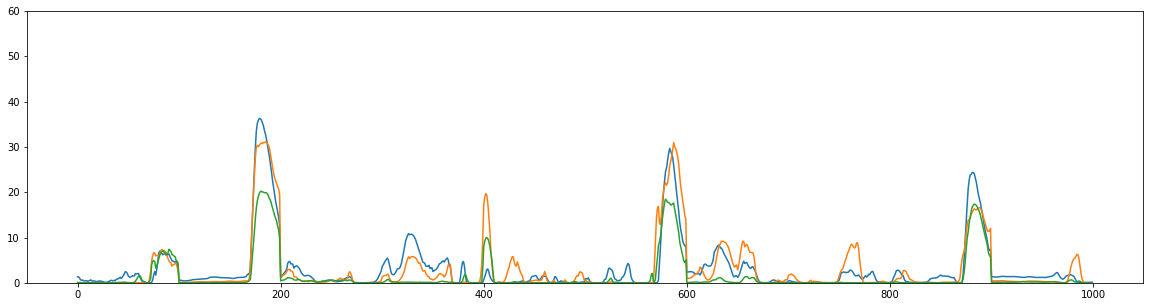

In [306]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
print(test_pc)
plt.figure(figsize=(20,5))
plt.plot(targ[1000:2000, [2,3,5]])
plt.ylim(0,120)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(pred[1000:2000, [2,3,5]])
plt.ylim(0,120)
plt.show()
plt.figure(figsize=(20,5))
plt.ylim(0,60)
plt.plot(targ[1000:2000, [0,1,4]])
plt.show()
plt.figure(figsize=(20,5))
plt.ylim(0,60)
plt.plot(pred[1000:2000, [0,1,4]])
plt.show()

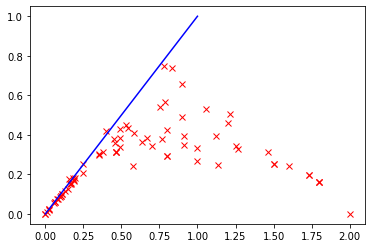

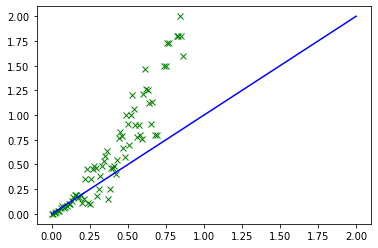

In [307]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _, _ = recording.stats_rate(pred, cell=3, rate=rate)
    #mean, var, _, _ = recording.stats_rate(targ, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

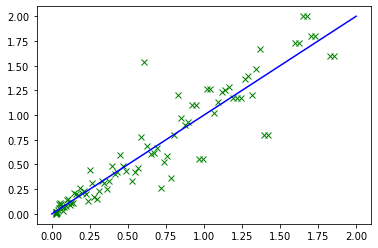

In [270]:
poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 3, full=True)[0]
plt.plot([np.polyval(poly_para, x) for x in rates], means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

In [322]:
poly_paras = []
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred, cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 3, full=True)[0]
    poly_paras.append(poly_para)
poly_paras

[array([-2.63493187e+01,  1.40585371e+01, -4.63224867e-01,  1.62135759e-02]),
 array([12.16485787, -5.68575577,  1.99321953, -0.04000167]),
 array([1.86920602, 3.25696138, 0.16266602, 0.0039137 ]),
 array([ 0.09650178,  1.5686009 ,  0.74954716, -0.00236915]),
 array([-1.68545439e+01,  4.64400996e+00,  9.29701208e-01, -2.56537123e-03]),
 array([ 4.65411953, -3.34240026,  1.89513997, -0.04647712])]

In [309]:
pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred.shape[1]):
    dist = distribution(t_list[cell])
    for t in range(pred.shape[0]):
        rate = np.polyval(poly_paras[cell], pred[t, cell]/100)*100
        if rate <= 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para['binomial'][cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para['binomial'][cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], 15, p=p)
        pred_single_trial[:, t, cell] = spikes

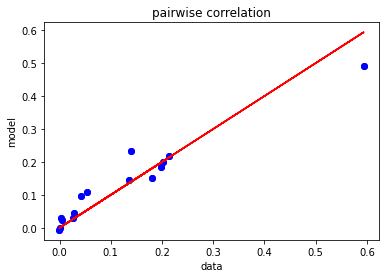

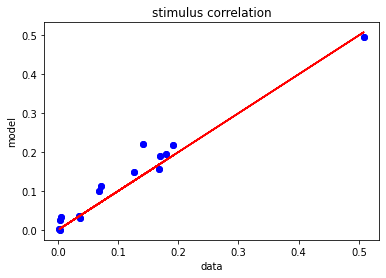

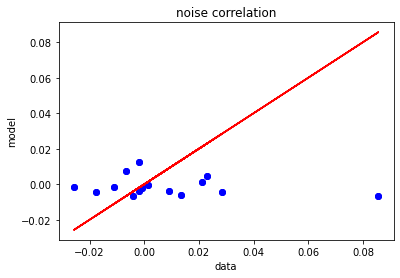

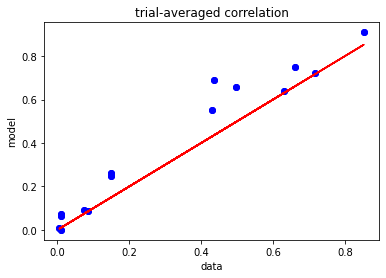

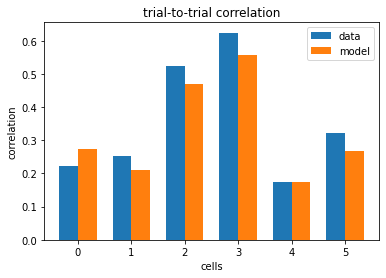

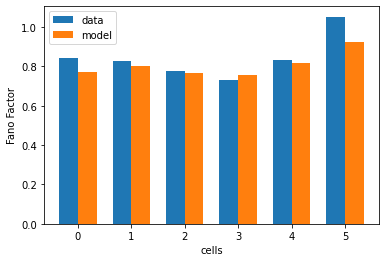

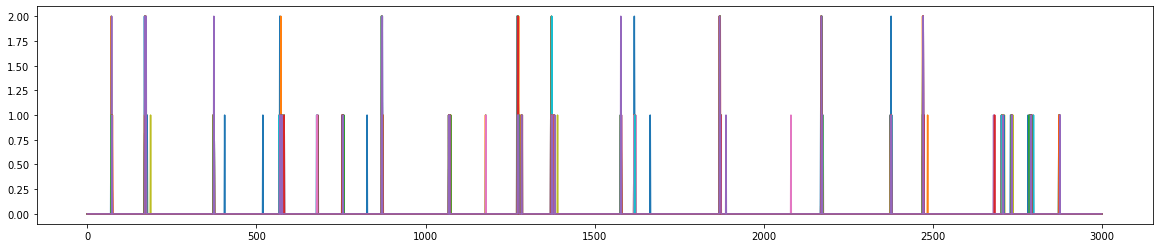

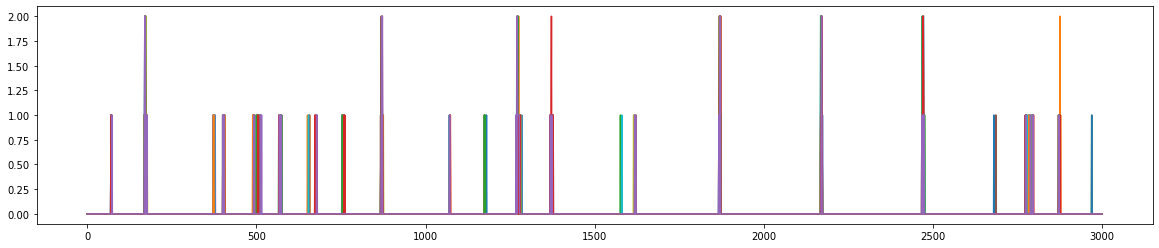

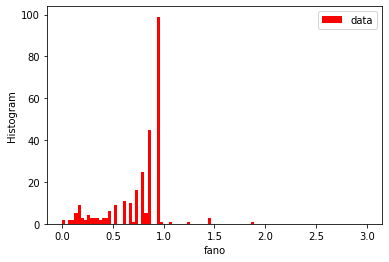

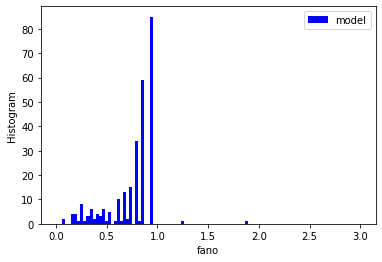

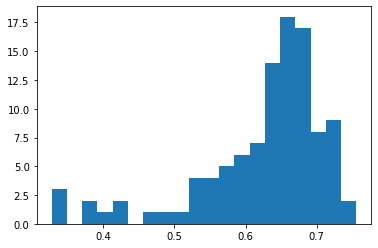

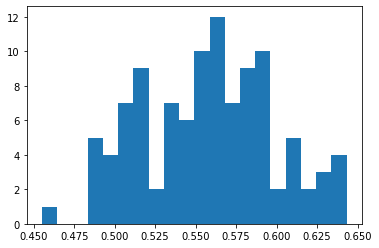

In [311]:
pred_single_trial[:, pred<2] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial[i,:,cell], pred_single_trial[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

In [315]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
error = 0
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred, cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    error += np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 3, full=True)[1]
error

array([3.66268332])

In [316]:
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.25, 0])
pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

In [11]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_poly')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_Poly/epoch_000_loss_nan_pearson_0.7692.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
error = 0
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred, cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    error += np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[1]
error

array([21.13876061])

In [388]:
optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]

In [389]:
pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes

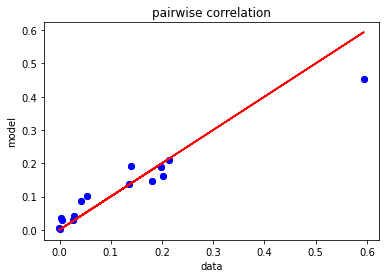

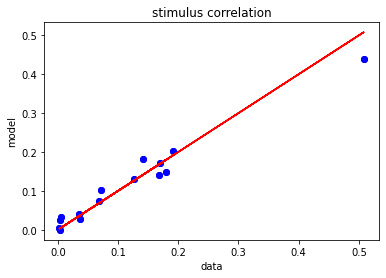

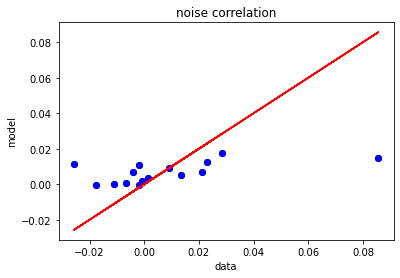

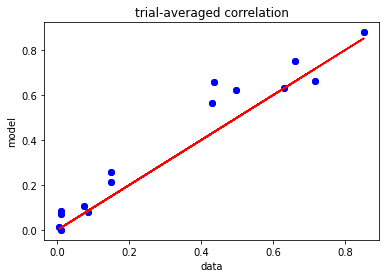

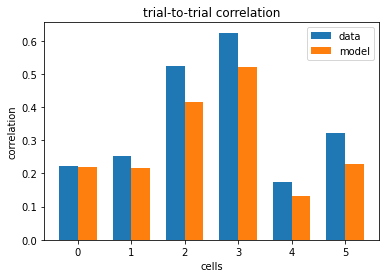

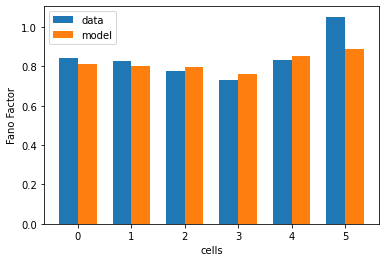

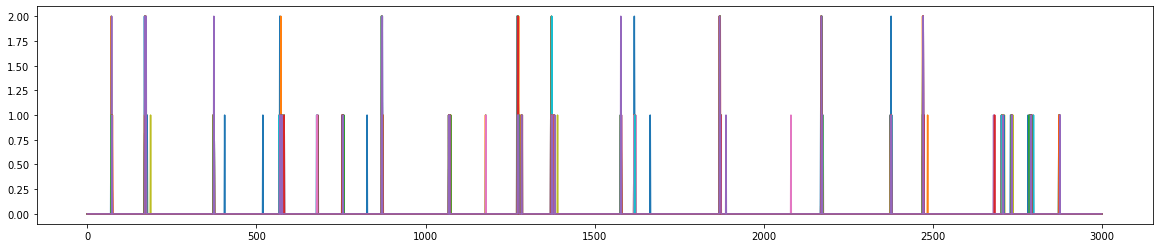

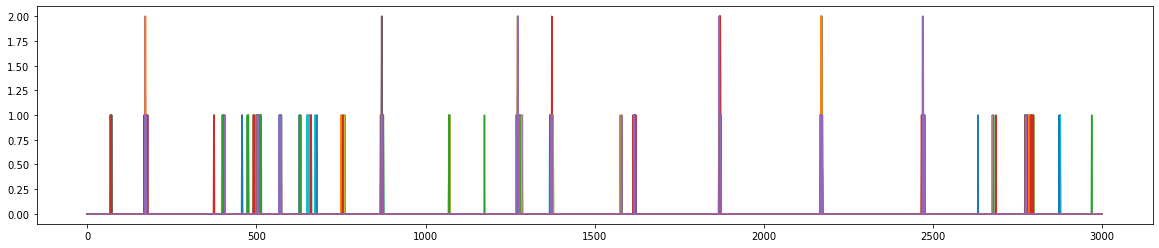

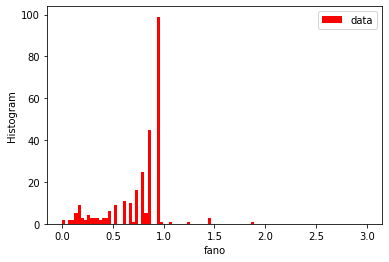

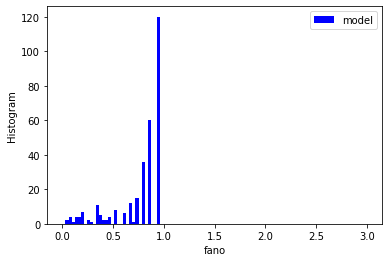

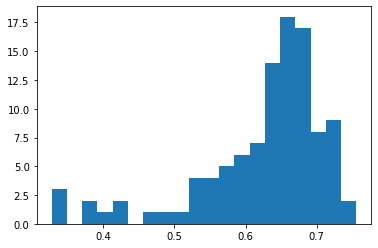

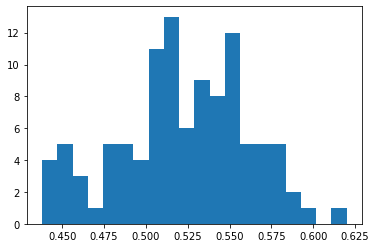

In [390]:
pred_single_trial[:, pred<3] = 0
#pred_single_trial[pred_single_trial_pre<5] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial[i,:,cell], pred_single_trial[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

In [383]:
num_cells = 6
num_trials = 15
min_error = 10

torch.manual_seed(9)
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.25, 0])
pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]

for i in range(100):
    np.random.seed(i)
    pred_single_trial = np.zeros(single_trial_bin.shape)
    for cell in range(pred_single_trial_pre.shape[-1]):
        dist = distribution(t_list[cell])
        pred_scale = np.polyval(poly_paras[cell], pred_single_trial_pre[:, :, cell]/100)*100
        for rate in range((t_list[cell]-1)*100):
            indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
            num = indices[0].shape[0]
            if num == 0:
                continue
            r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
            p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
            spikes = np.random.choice(t_list[cell], num, p=p)
            pred_single_trial[:, :, cell][indices] = spikes
        indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes

    pred_single_trial[:, pred<3] = 0 
    diagonal_idxs = list(range(0,6*6, 6+1))

    corr = single_trial_corr_matrix(num_cells, num_trials, single_trial_bin)
    pred_corr = single_trial_corr_matrix(num_cells, num_trials, pred_single_trial)

    stim_corr = stimuli_corr_matrix(num_cells, num_trials, single_trial_bin)
    noise_corr = corr - stim_corr
    pred_stim_corr = stimuli_corr_matrix(num_cells, num_trials, pred_single_trial)
    pred_noise_corr = pred_corr - pred_stim_corr
    noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs)
    pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)
    error = np.abs(pred_noise_corr - noise_corr).sum()
    if error < min_error:
        min_error = error
        min_seed = i
print(min_seed, min_error)

1 0.3014234814018384


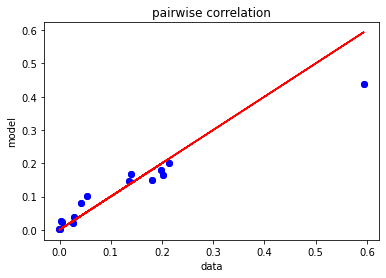

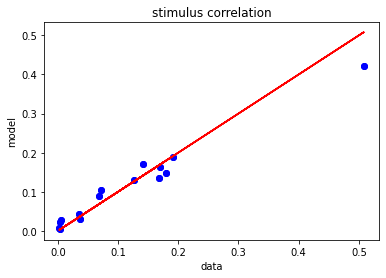

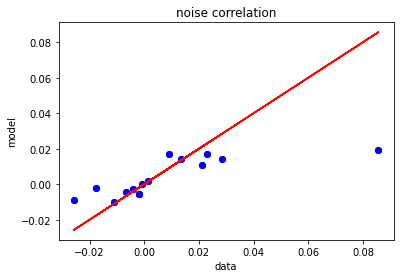

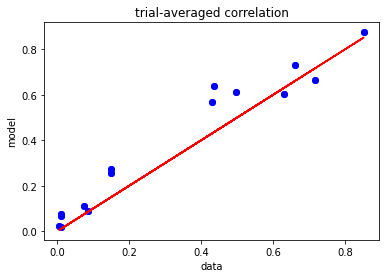

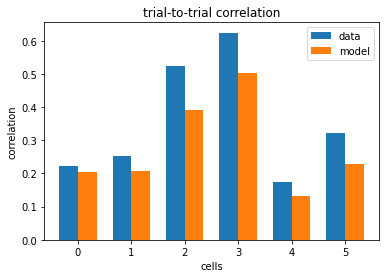

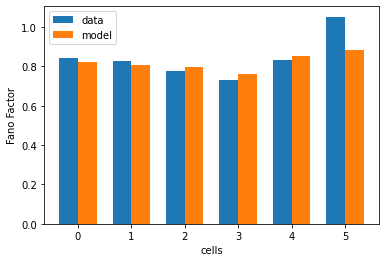

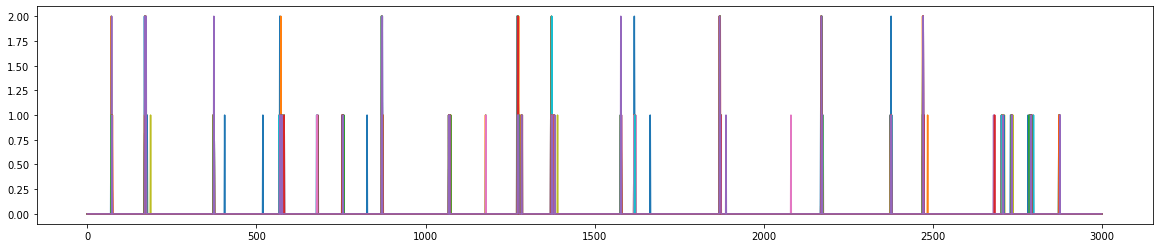

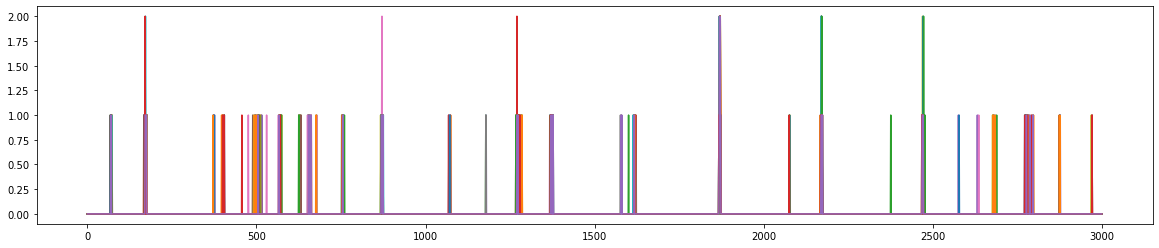

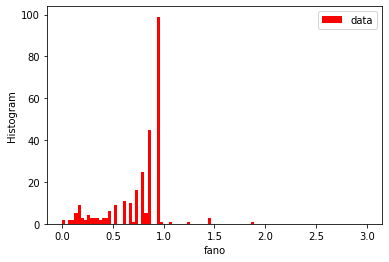

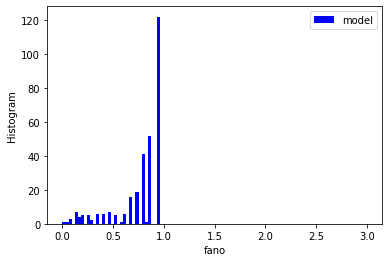

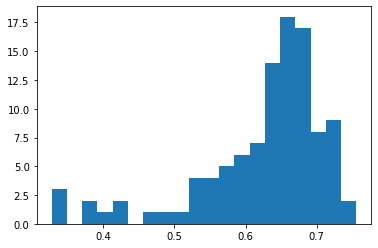

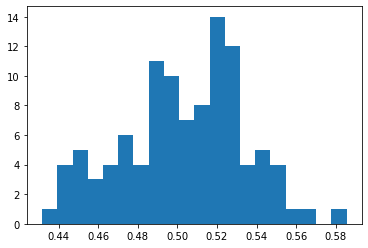

In [384]:
np.random.seed(1)
pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes

pred_single_trial[:, pred<3] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial[i,:,cell], pred_single_trial[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

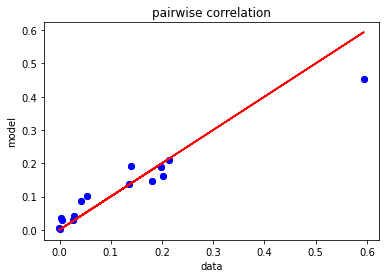

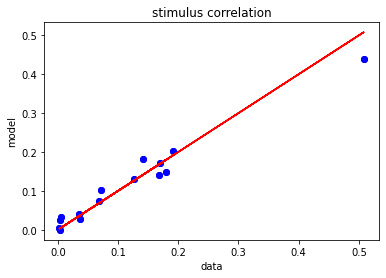

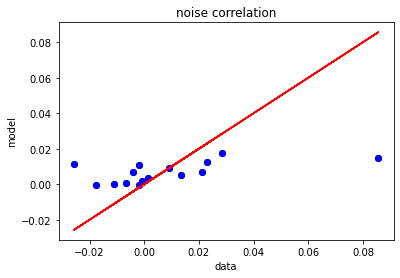

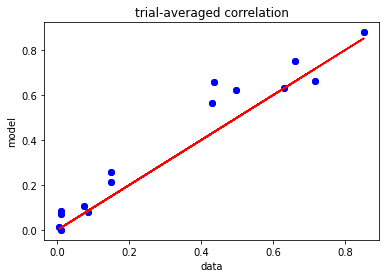

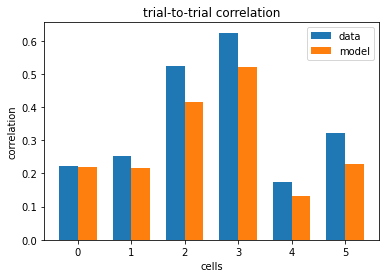

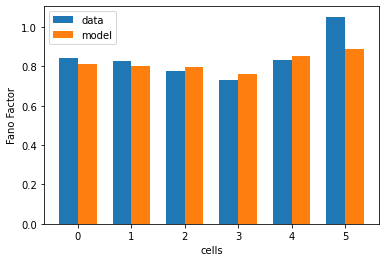

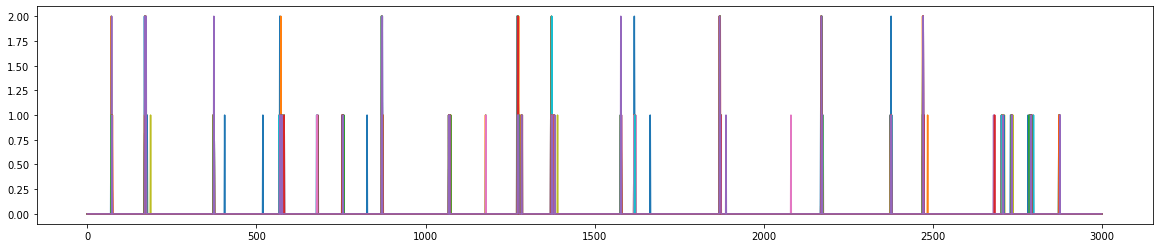

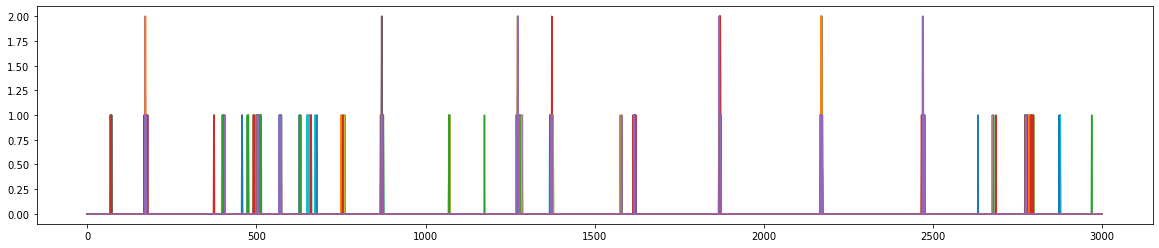

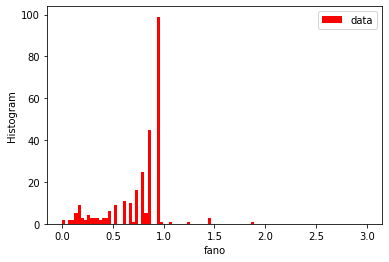

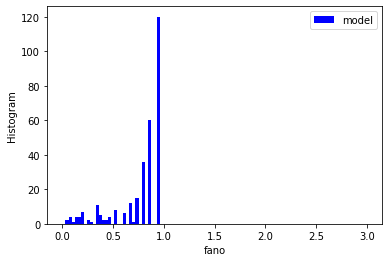

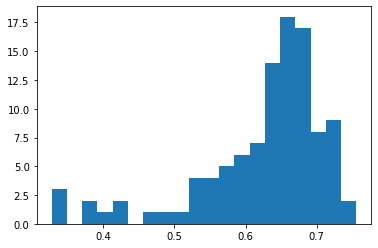

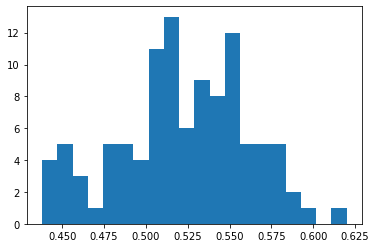

In [392]:
optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]

#np.random.seed(10)
pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes

pred_single_trial[:, pred<3] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial[i,:,cell], pred_single_trial[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

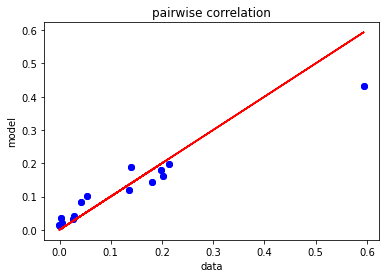

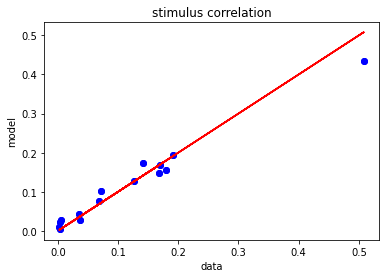

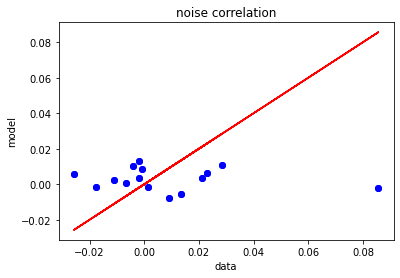

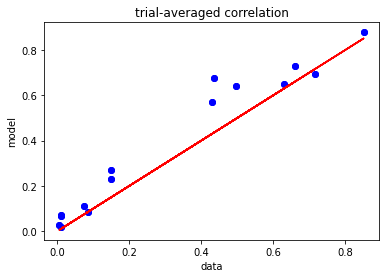

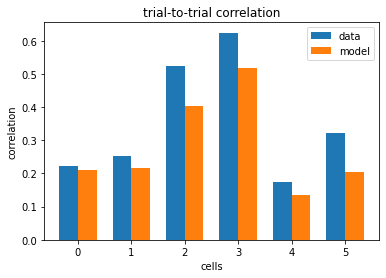

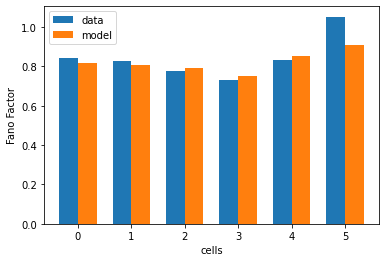

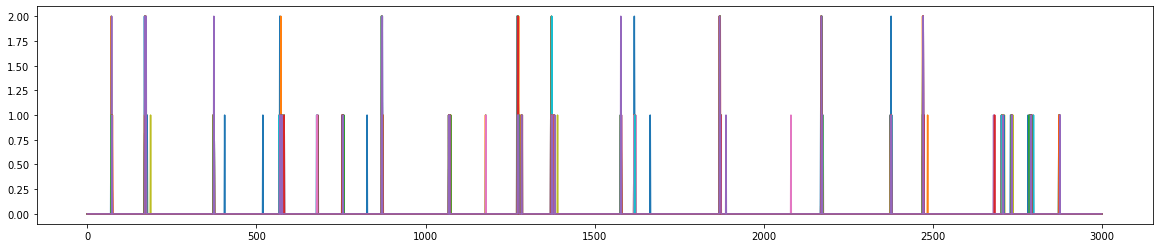

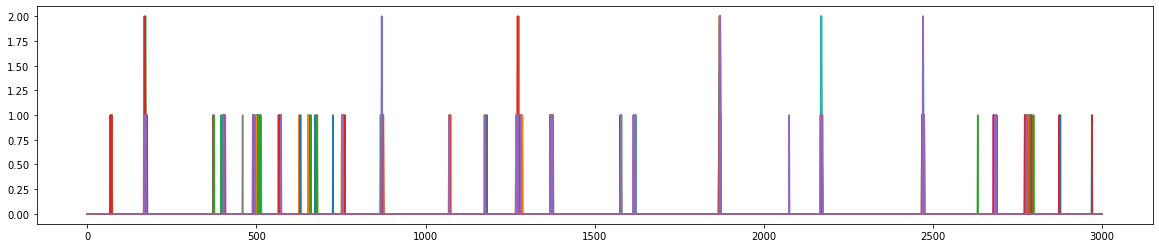

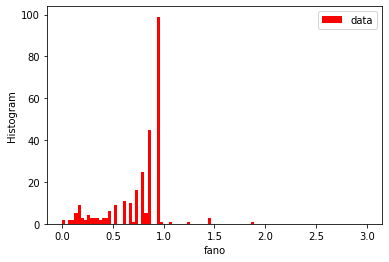

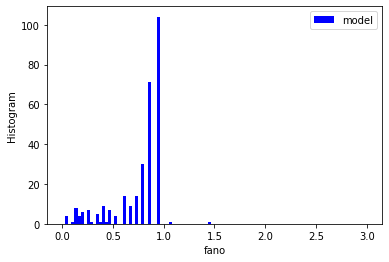

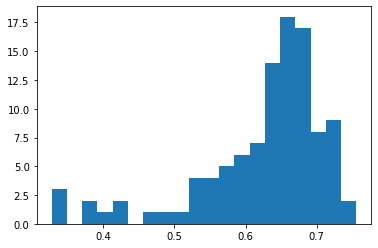

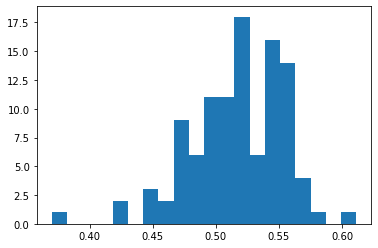

In [407]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

t = 1000 * time.time()
np.random.seed(int(t) % 2**32)

poly_paras = []
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred, cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 3, full=True)[0]
    poly_paras.append(poly_para)
    
optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]

pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.25, 0])
pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes


pred_single_trial[:, pred<3] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial[i,:,cell], pred_single_trial[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

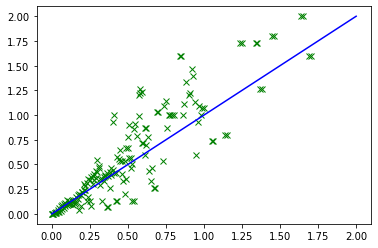

In [408]:
pred_scale_all = []
for cell in range(6):
    pred_scale = np.polyval(poly_paras[cell], pred_single_trial_pre[:, :, cell]/100)*100
    pred_scale_all.append(pred_scale.mean(0))
pred_scale_all = np.array(pred_scale_all).T

for rate in range(200):
    mean, var, _, _ = recording.stats_rate(pred_scale_all, cell=3, rate=rate)
    means.append(mean)
    rates.append(rate/100)
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

In [413]:
poly_paras2 = []
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
    poly_paras2.append(poly_para)

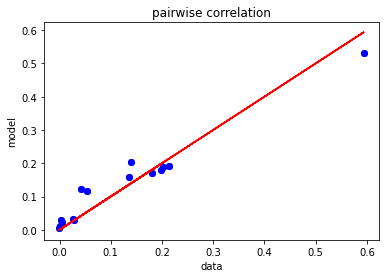

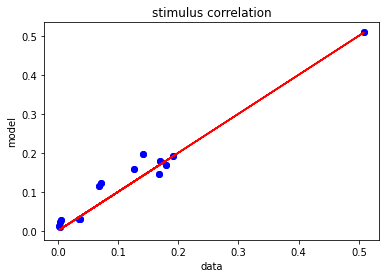

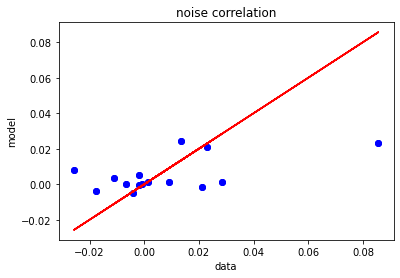

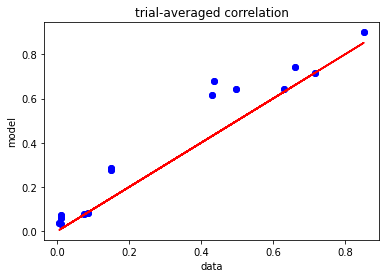

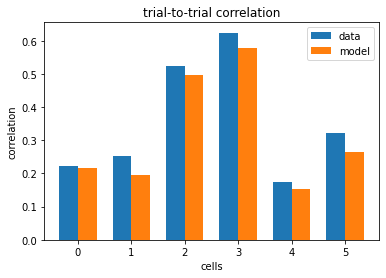

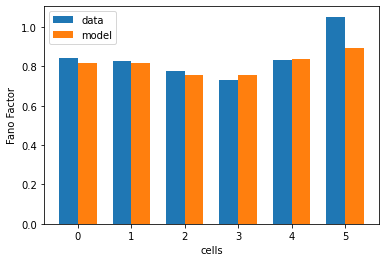

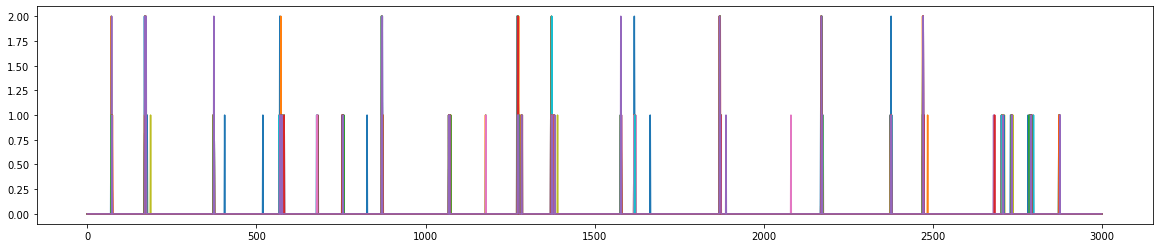

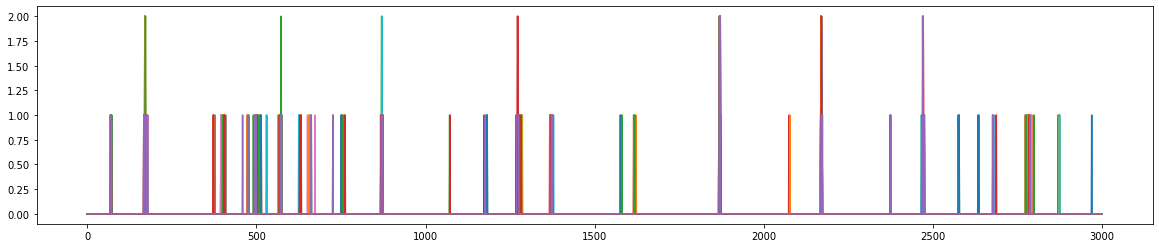

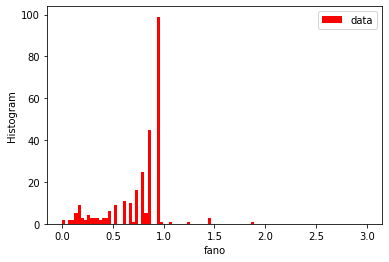

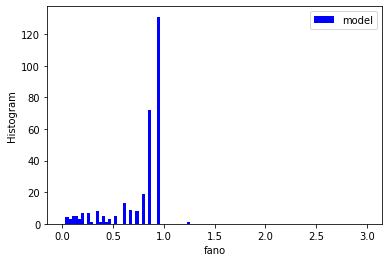

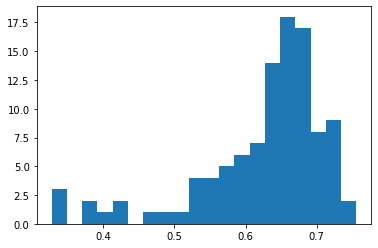

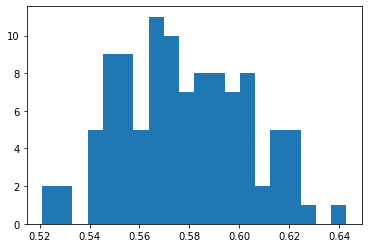

In [414]:
pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes


pred_single_trial[:, pred<3] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial[i,:,cell], pred_single_trial[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

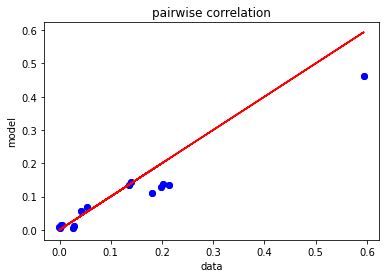

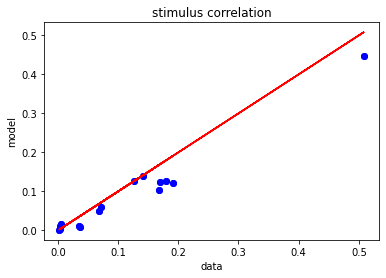

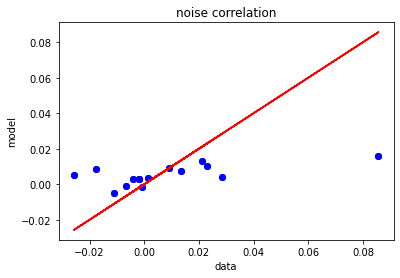

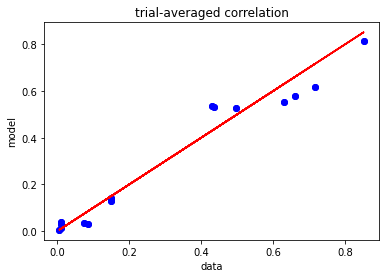

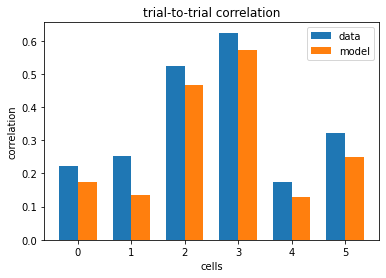

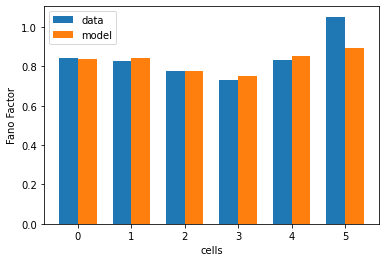

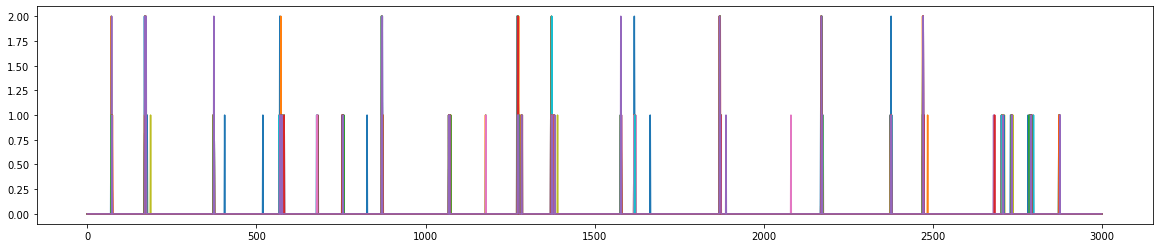

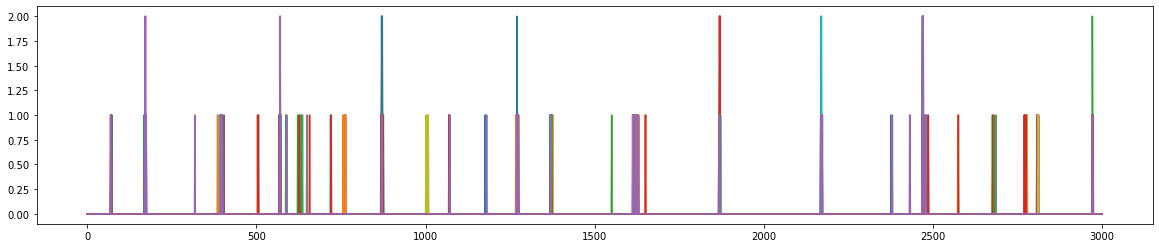

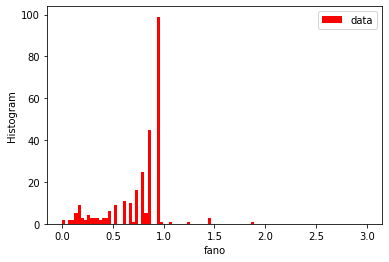

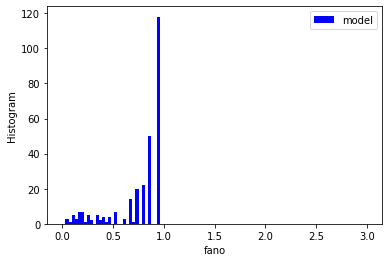

In [418]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
    
optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]

pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.25, 0])
pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

poly_paras2 = []
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
    poly_paras2.append(poly_para)

pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes


pred_single_trial[:, pred<3] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()

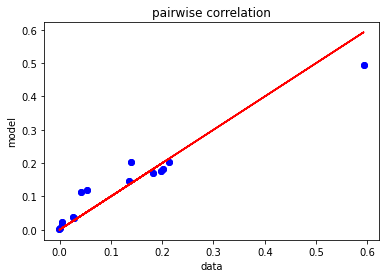

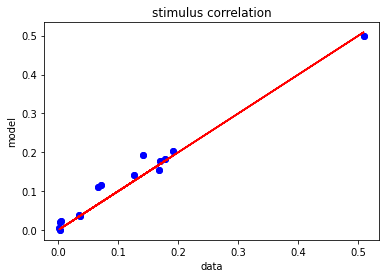

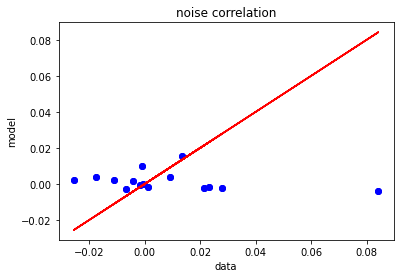

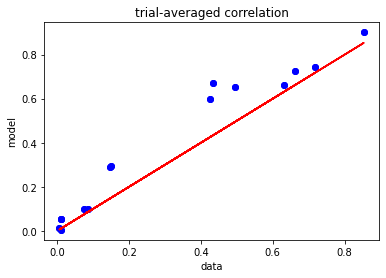

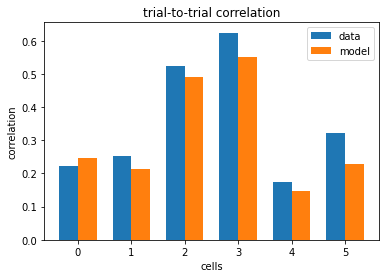

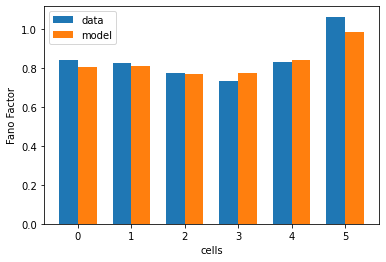

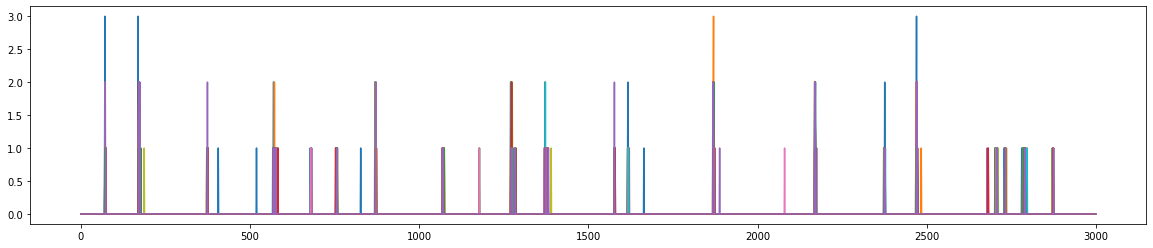

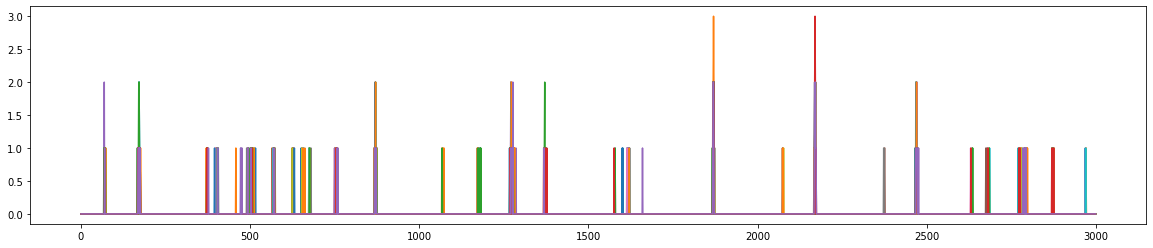

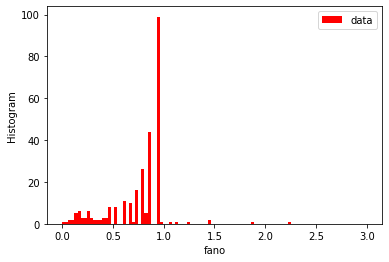

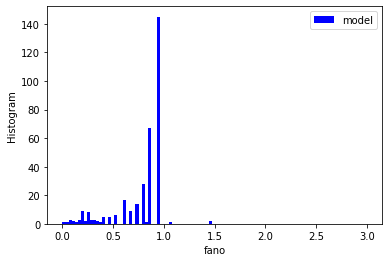

In [21]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
    
#optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]
optimum_para_2 = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]

pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.15, 0])
pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

poly_paras2 = []
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
    poly_paras2.append(poly_para)

pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes


pred_single_trial[:, pred<3] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()

In [420]:
optimum_para

{'gaussian': [0.61, 0.56, 0.56, 0.66, 1.0, 0.94],
 'poisson1': [5.56, 8.87, 4.65, 4.75, 1.0, 1.49],
 'poisson2': [3.81, 5.03, 3.3, 3.11, 6.1, 0.82],
 'binomial': [2.17, 2.85, 1.91, 1.69, 1.0, 0.47]}

In [425]:
poly_paras2

[array([-1.69427644e+01, -1.99121931e+01,  1.40154699e+01, -5.14862608e-01,
         1.21469143e-02]),
 array([ 1.46294567e+02, -1.16804574e+02,  3.02638843e+01, -1.44447925e+00,
         1.36165288e-02]),
 array([ 7.65467192e+01, -7.16125706e+01,  2.38642848e+01, -8.97756935e-01,
         1.97188437e-02]),
 array([ 3.0830605 , -5.36606894,  4.77277714,  0.33865426,  0.0059114 ]),
 array([ 3.18999683e+02, -1.87969653e+02,  2.99298451e+01,  9.35107706e-02,
         2.33408897e-03]),
 array([-5.83185557e+01,  5.94854001e+01, -1.92749659e+01,  3.73210547e+00,
        -3.97937744e-02])]

In [426]:
poly_paras

[array([-2.63493187e+01,  1.40585371e+01, -4.63224867e-01,  1.62135759e-02]),
 array([12.16485787, -5.68575577,  1.99321953, -0.04000167]),
 array([1.86920602, 3.25696138, 0.16266602, 0.0039137 ]),
 array([ 0.09650178,  1.5686009 ,  0.74954716, -0.00236915]),
 array([-1.68545439e+01,  4.64400996e+00,  9.29701208e-01, -2.56537123e-03]),
 array([ 4.65411953, -3.34240026,  1.89513997, -0.04647712])]

In [29]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
    
#optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]
optimum_para_2 = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]

torch.manual_seed(55)
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.25, 0])
pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

poly_paras2 = []
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
    poly_paras2.append(poly_para)

num_cells = 6
num_trials = 15
min_error = 10

for i in range(100):
    np.random.seed(i)
    pred_single_trial = np.zeros(single_trial_bin.shape)
    for cell in range(pred_single_trial_pre.shape[-1]):
        dist = distribution(t_list[cell])
        pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
        for rate in range((t_list[cell]-1)*100):
            indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
            num = indices[0].shape[0]
            if num == 0:
                continue
            r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
            p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
            spikes = np.random.choice(t_list[cell], num, p=p)
            pred_single_trial[:, :, cell][indices] = spikes
        indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes


    pred_single_trial[:, pred<3] = 0
    diagonal_idxs = list(range(0,6*6, 6+1))

    corr = single_trial_corr_matrix(num_cells, num_trials, single_trial_bin)
    pred_corr = single_trial_corr_matrix(num_cells, num_trials, pred_single_trial)

    stim_corr = stimuli_corr_matrix(num_cells, num_trials, single_trial_bin)
    noise_corr = corr - stim_corr
    pred_stim_corr = stimuli_corr_matrix(num_cells, num_trials, pred_single_trial)
    pred_noise_corr = pred_corr - pred_stim_corr
    noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs)
    pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)
    error = np.abs(pred_noise_corr - noise_corr).sum()
    if error < min_error:
        min_error = error
        min_seed = i
print(min_seed, min_error)

16 0.3622016395001795


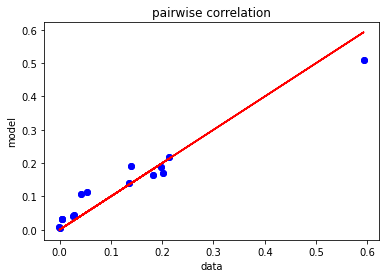

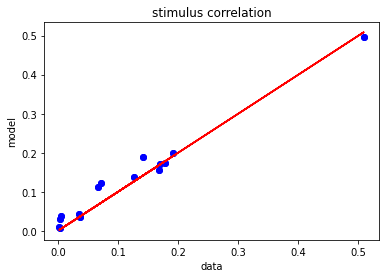

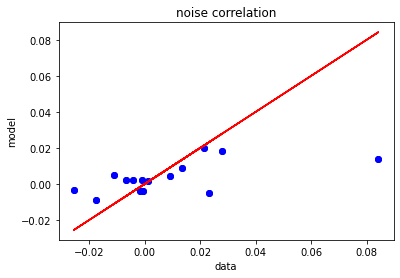

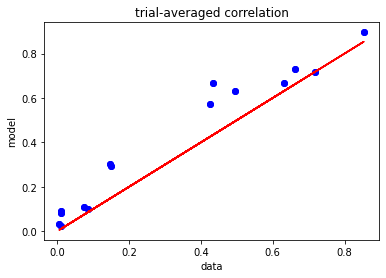

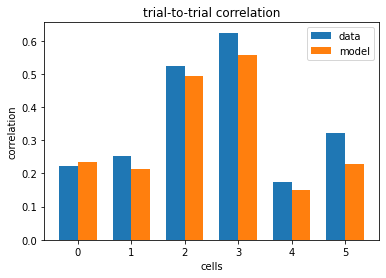

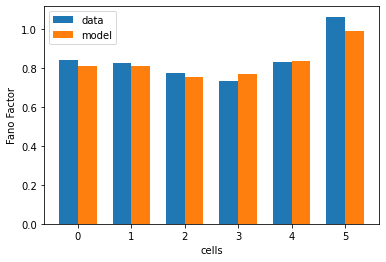

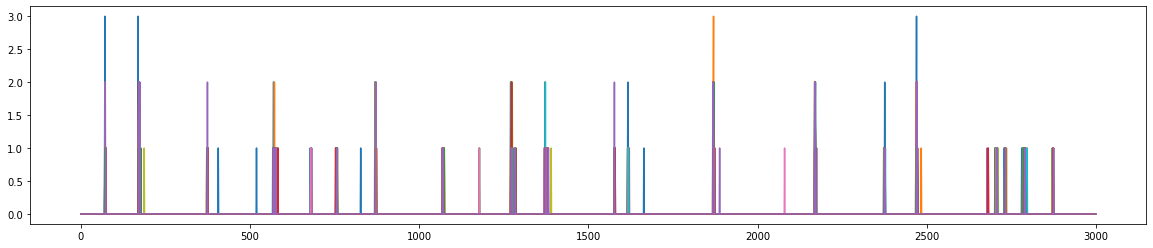

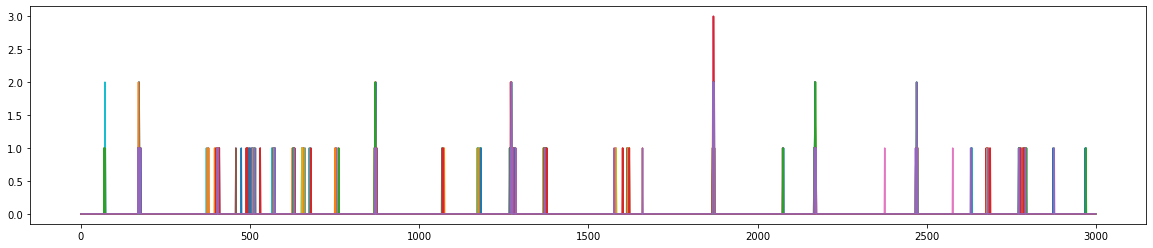

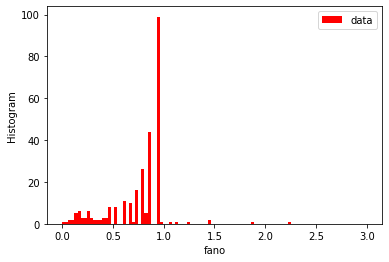

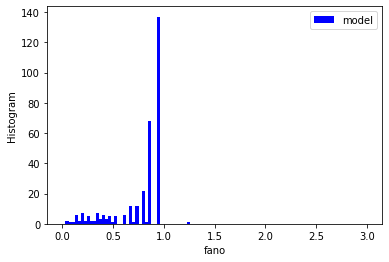

In [23]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
    
#optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]
optimum_para_2 = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]

torch.manual_seed(9)
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.15, 0])
pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

poly_paras2 = []
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
    poly_paras2.append(poly_para)

num_cells = 6
num_trials = 15
min_error = 10


np.random.seed(40)
pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes


pred_single_trial[:, pred<3] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()

In [27]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
    
#optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]
optimum_para_2 = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]

num_cells = 6
num_trials = 15
min_error = 10
for i in range(100):

    torch.manual_seed(i)
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.25, 0])
    pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

    poly_paras2 = []
    for cell in range(6):
        means = []
        rates = []
        for rate in range(200):
            mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
            means.append(mean)
            rates.append(rate/100)
        poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
        poly_paras2.append(poly_para)

    np.random.seed(i)
    pred_single_trial = np.zeros(single_trial_bin.shape)
    for cell in range(pred_single_trial_pre.shape[-1]):
        dist = distribution(t_list[cell])
        pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
        for rate in range((t_list[cell]-1)*100):
            indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
            num = indices[0].shape[0]
            if num == 0:
                continue
            r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
            p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
            spikes = np.random.choice(t_list[cell], num, p=p)
            pred_single_trial[:, :, cell][indices] = spikes
        indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes


    pred_single_trial[:, pred<3] = 0
    diagonal_idxs = list(range(0,6*6, 6+1))

    corr = single_trial_corr_matrix(num_cells, num_trials, single_trial_bin)
    pred_corr = single_trial_corr_matrix(num_cells, num_trials, pred_single_trial)

    stim_corr = stimuli_corr_matrix(num_cells, num_trials, single_trial_bin)
    noise_corr = corr - stim_corr
    pred_stim_corr = stimuli_corr_matrix(num_cells, num_trials, pred_single_trial)
    pred_noise_corr = pred_corr - pred_stim_corr
    noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs)
    pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)
    corr = np.delete(corr.flatten(), diagonal_idxs)
    pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
    error_corr = np.abs(pred_corr - corr).sum() / corr.sum()
    error_noise = np.abs(pred_noise_corr - noise_corr).sum() / np.abs(noise_corr).sum()
    error = error_corr + error_noise
    if error < min_error:
        min_error = error
        min_seed = i
print(min_seed, min_error)

55 0.9534914847599365


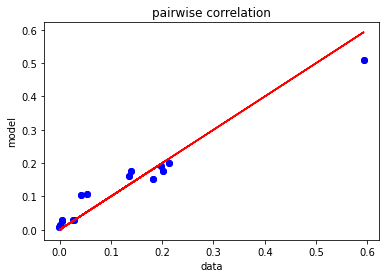

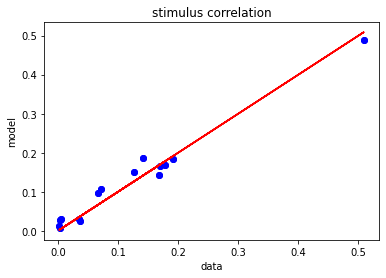

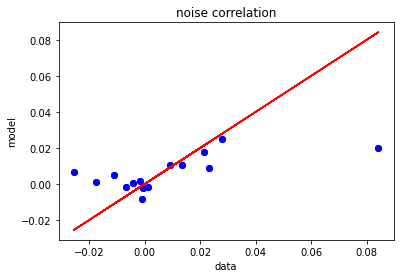

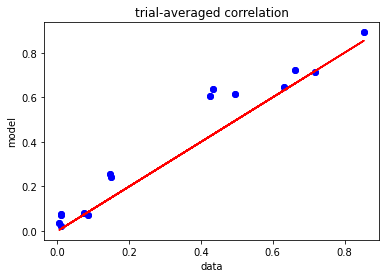

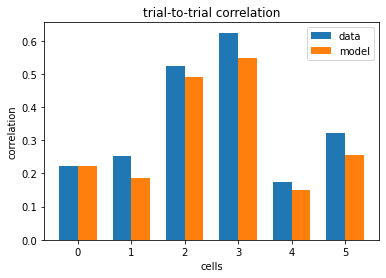

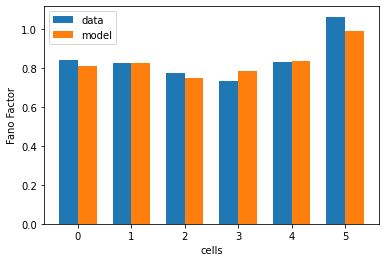

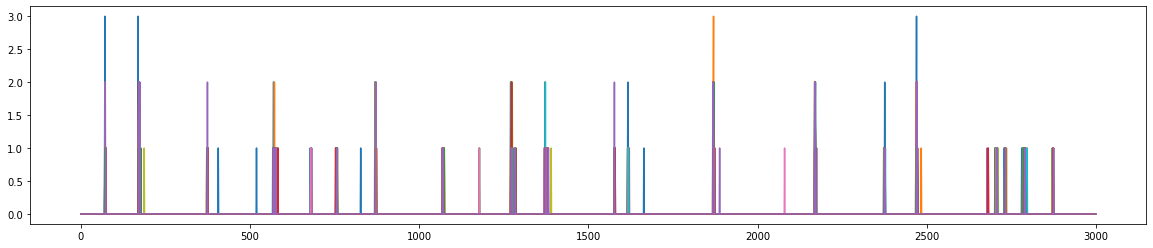

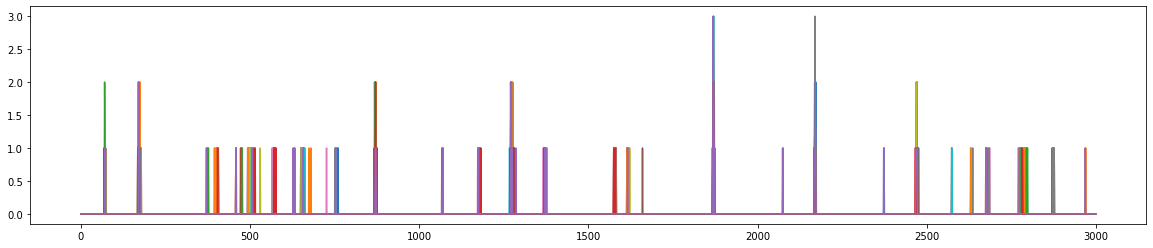

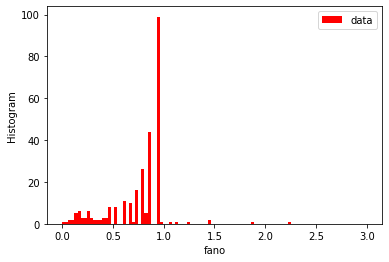

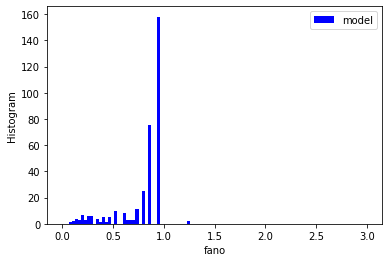

In [30]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
    
#optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]
optimum_para_2 = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]

num_cells = 6
num_trials = 15
min_error = 10

torch.manual_seed(55)
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.25, 0])
pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

poly_paras2 = []
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
    poly_paras2.append(poly_para)

np.random.seed(16)
pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes


pred_single_trial[:, pred<3] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()

In [31]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
    
#optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]
optimum_para_2 = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]

num_cells = 6
num_trials = 15
min_error = 10
for i in range(100):

    torch.manual_seed(i)
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.25, 0])
    pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

    poly_paras2 = []
    for cell in range(6):
        means = []
        rates = []
        for rate in range(200):
            mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
            means.append(mean)
            rates.append(rate/100)
        poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
        poly_paras2.append(poly_para)

    np.random.seed(i)
    pred_single_trial = np.zeros(single_trial_bin.shape)
    for cell in range(pred_single_trial_pre.shape[-1]):
        dist = distribution(t_list[cell])
        pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
        for rate in range((t_list[cell]-1)*100):
            indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
            num = indices[0].shape[0]
            if num == 0:
                continue
            r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
            p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
            spikes = np.random.choice(t_list[cell], num, p=p)
            pred_single_trial[:, :, cell][indices] = spikes
        indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes


    pred_single_trial[:, pred<3] = 0
    diagonal_idxs = list(range(0,6*6, 6+1))

    corr = single_trial_corr_matrix(num_cells, num_trials, single_trial_bin)
    pred_corr = single_trial_corr_matrix(num_cells, num_trials, pred_single_trial)

    stim_corr = stimuli_corr_matrix(num_cells, num_trials, single_trial_bin)
    noise_corr = corr - stim_corr
    pred_stim_corr = stimuli_corr_matrix(num_cells, num_trials, pred_single_trial)
    pred_noise_corr = pred_corr - pred_stim_corr
    noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs)
    pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)
    corr = np.delete(corr.flatten(), diagonal_idxs)
    pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
    error = np.abs(pred_noise_corr - noise_corr).sum()
    if error < min_error:
        min_error = error
        min_seed = i
print(min_seed, min_error)

55 0.3672538202553799


In [44]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
    
#optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]
optimum_para_2 = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]

num_cells = 6
num_trials = 15
min_error = 10
for i in range(100):

    torch.manual_seed(i)
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0.25, 0, 0, 0])
    pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

    poly_paras2 = []
    for cell in range(6):
        means = []
        rates = []
        for rate in range(200):
            mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
            means.append(mean)
            rates.append(rate/100)
        poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
        poly_paras2.append(poly_para)

    np.random.seed(i)
    pred_single_trial = np.zeros(single_trial_bin.shape)
    for cell in range(pred_single_trial_pre.shape[-1]):
        dist = distribution(t_list[cell])
        pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
        for rate in range((t_list[cell]-1)*100):
            indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
            num = indices[0].shape[0]
            if num == 0:
                continue
            r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
            p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
            spikes = np.random.choice(t_list[cell], num, p=p)
            pred_single_trial[:, :, cell][indices] = spikes
        indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes


    pred_single_trial[:, pred<3] = 0
    diagonal_idxs = list(range(0,6*6, 6+1))

    corr = single_trial_corr_matrix(num_cells, num_trials, single_trial_bin)
    pred_corr = single_trial_corr_matrix(num_cells, num_trials, pred_single_trial)

    stim_corr = stimuli_corr_matrix(num_cells, num_trials, single_trial_bin)
    noise_corr = corr - stim_corr
    pred_stim_corr = stimuli_corr_matrix(num_cells, num_trials, pred_single_trial)
    pred_noise_corr = pred_corr - pred_stim_corr
    noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs)
    pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)
    corr = np.delete(corr.flatten(), diagonal_idxs)
    pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
    error = np.abs(pred_noise_corr - noise_corr).sum()
    if error < min_error:
        min_error = error
        min_seed = i
print(min_seed, min_error)

76 0.3614157799733487


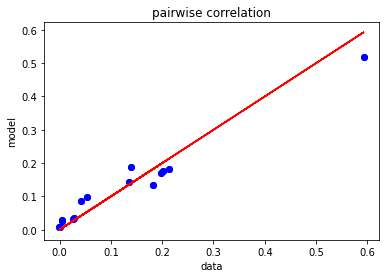

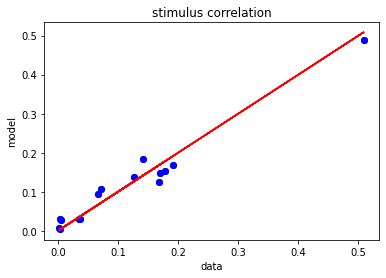

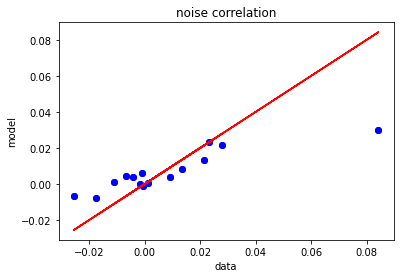

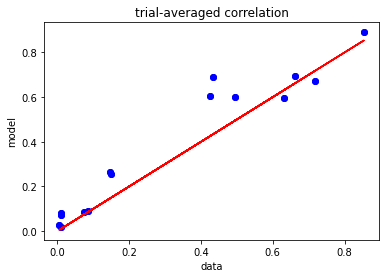

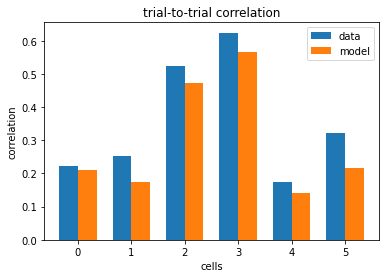

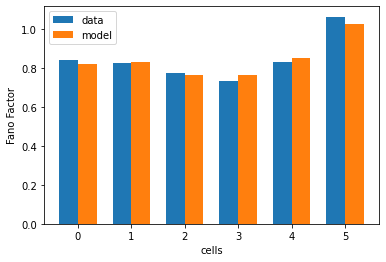

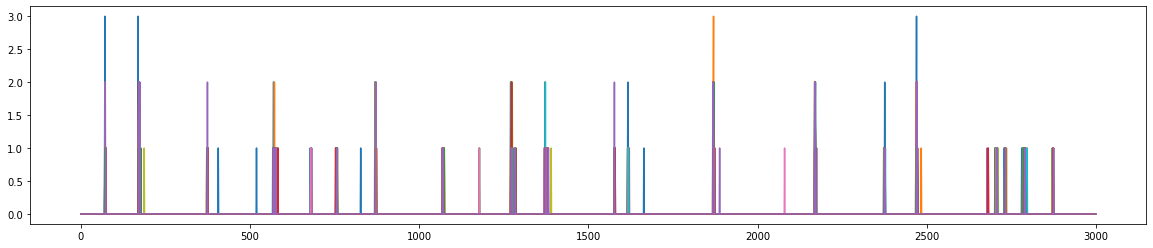

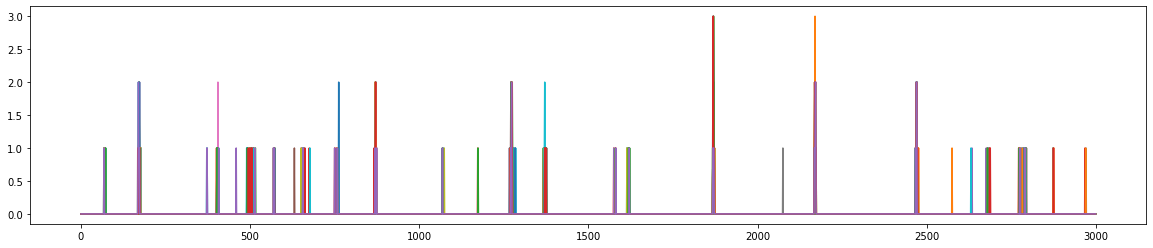

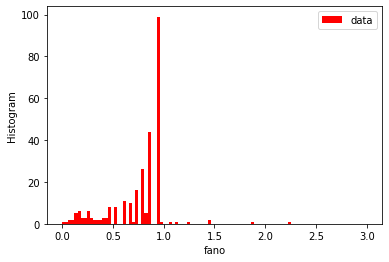

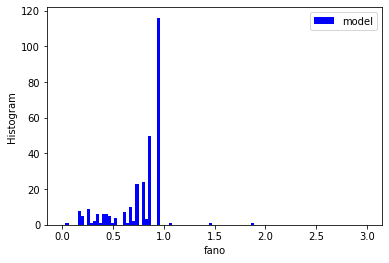

In [34]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-4.05_pearson_0.6821.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_085_loss_61.82_pearson_0.7193.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
    
#optimum_para_2 = [2.6, 3.5, 2.8, 2.8, 1.5, 0.9]
optimum_para_2 = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]

num_cells = 6
num_trials = 15
min_error = 10

torch.manual_seed(39)
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, gaussian=[0., 0., 0.3, 0])
pred_single_trial_pre = pred_single_trial_pre.detach().cpu().numpy()

poly_paras2 = []
for cell in range(6):
    means = []
    rates = []
    for rate in range(200):
        mean, var, _, _ = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate)
        means.append(mean)
        rates.append(rate/100)
    poly_para = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 4, full=True)[0]
    poly_paras2.append(poly_para)

np.random.seed(39)
pred_single_trial = np.zeros(single_trial_bin.shape)
for cell in range(pred_single_trial_pre.shape[-1]):
    dist = distribution(t_list[cell])
    pred_scale = np.polyval(poly_paras2[cell], pred_single_trial_pre[:, :, cell]/100)*100
    for rate in range((t_list[cell]-1)*100):
        indices = np.where((pred_scale>=rate-0.5)*(pred_scale<rate+0.5))
        num = indices[0].shape[0]
        if num == 0:
            continue
        r = dist.rate2para('binomial_scale', optimum_para_2[cell], rate)
        p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
        spikes = np.random.choice(t_list[cell], num, p=p)
        pred_single_trial[:, :, cell][indices] = spikes
    indices = np.where(pred_scale>=(t_list[cell]-1)*100-0.5)
    num = indices[0].shape[0]
    if num == 0:
        continue
    r = dist.rate2para('binomial_scale', optimum_para_2[cell], (t_list[cell]-1)*100)
    p = [dist.binomial_scale(i, r, optimum_para_2[cell]) for i in range(t_list[cell])]
    spikes = np.random.choice(t_list[cell], num, p=p)
    pred_single_trial[:, :, cell][indices] = spikes


pred_single_trial[:, pred<3] = 0
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)
correlation_plot(norm_single_trial_bin, pred_single_trial, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()